In [2]:
# The following pytorch code is based on
# https://github.com/snowbbbb/code-for-Global-Convergence-of-Over-parameterized-Deep-Equilibrium-Models

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import math
from torch.utils.data import TensorDataset, DataLoader
import torch.autograd as autograd
from torch.utils.data import ConcatDataset

# Set the visible GPU device if running on CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Optional: Random seed setup for reproducibility
SEED = 2
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)  # If using GPU
torch.backends.cudnn.deterministic = True  # Ensure deterministic results with CUDA
torch.backends.cudnn.benchmark = False  # Disable cudnn benchmarking for

In [3]:
# Set dataset root directory
root_train = '/Users/lantruong/Dataset/MNIST/'

# Define transformation (Grayscale and ToTensor)
trainTransform = transforms.Compose([transforms.Grayscale(1), transforms.ToTensor()])

# Load the MNIST dataset
trainset_full = torchvision.datasets.MNIST(root=root_train, train=True, download=True, transform=trainTransform)
print("Full trainset length:", len(trainset_full))

# Using the whole dataset
trainset = trainset_full  # Use all the classes in CIFAR-10
print("Using the full MNIST dataset with all classes.")

Full trainset length: 60000
Using the full MNIST dataset with all classes.


In [4]:
# Download and define the training set.
samplesize = 10000
netDepth = 2

# DataLoader to load the MNIST training data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True, num_workers=0)
print(len(trainloader.dataset))
batchsize = 1000
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = torch.flatten(images, start_dim=1)
images = F.normalize(images, p=2, dim=1)

# Here, `labels` contains the actual class labels for CIFAR-10 images
train_ids = TensorDataset(images, labels)  # Use the true labels, not random labels
trainloader = torch.utils.data.DataLoader(dataset=train_ids, batch_size=len(train_ids), shuffle=True, num_workers=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

output_size = 1

60000


In [4]:
def FPiter(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta=1.0):
    #Anderson acceleration for fixed point iteration
    bsz, D = x0.shape
    X = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, D, dtype=x0.dtype, device=x0.device)
    X[:, 0], F[:, 0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:, 1], F[:, 1] = F[:, 0], f(F[:, 0].view_as(x0)).view(bsz, -1)

    H = torch.zeros(bsz, m + 1, m + 1, dtype=x0.dtype, device=x0.device)
    H[:, 0, 1:] = H[:, 1:, 0] = 1
    y = torch.zeros(bsz, m + 1, 1, dtype=x0.dtype, device=x0.device)
    y[:, 0] = 1

    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:, :n] - X[:, :n]
        H[:, 1:n + 1, 1:n + 1] = torch.bmm(G, G.transpose(1, 2)) + lam * torch.eye(n, dtype=x0.dtype, device=x0.device)[
            None]
        alpha = torch.linalg.solve(H[:, :n + 1, :n + 1],y[:, :n + 1])[:, 1:n + 1, 0]  # (bsz x n)

        X[:, k % m] = beta * (alpha[:, None] @ F[:, :n])[:, 0] + (1 - beta) * (alpha[:, None] @ X[:, :n])[:, 0]
        F[:, k % m] = f(X[:, k % m].view_as(x0)).view(bsz, -1)
        res.append((F[:, k % m] - X[:, k % m]).norm().item() / (1e-5 + F[:, k % m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:, k % m].view_as(x0), res

In [5]:
class Net(nn.Module):
    def __init__(self, width,Wstd):
        super(Net, self).__init__()
        self.wmatrix=nn.Linear(width,width)
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)   


    def forward(self, z, x):
        y = F.tanh(self.wmatrix(z)+x) * (math.sqrt(1 / width))
        return y

In [6]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs

    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z: self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z, x)

        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0, x)

        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y: autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g

        z.register_hook(backward_hook)
        return z

In [7]:
def get_jacobian(model, x):
    nc = x.size()[0]
    ny = x.size()[2]
    nx = x.size()[1]
    noutputs = 10
    x = x.reshape(nc * nx * ny)
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = model(x.reshape(noutputs, nc, nx, ny))
    y.backward(torch.eye(noutputs).to(device))
    return x.grad.data

In [8]:
def setup_and_train(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = Net(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot   

In [29]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001

width=3000
loss_plot3000=setup_and_train(epochs, lr, 3000, Wstd)

width=4000
loss_plot4000=setup_and_train(epochs, lr, 4000, Wstd)

width=5000
loss_plot5000=setup_and_train(epochs, lr, 5000, Wstd)



lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.68s | loss 708.62 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.65s | loss 301.23 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.60s | loss 228.23 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.68s | loss 214.72 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.63s | loss 211.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.83s | loss 189.79 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.73s | loss 189.41 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.83s | loss 189.03 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.80s | loss 188.65 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.78s | loss 188.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.80s | loss 187.90 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.93s | loss 174.27 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.83s | loss 174.01 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.91s | loss 173.75 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.78s | loss 173.50 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.78s | loss 173.24 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.81s | loss 163.40 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.80s | loss 163.20 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.53s | loss 163.01 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.59s | loss 162.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.70s | loss 162.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8.68s | loss 162.43 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.77s | loss 154.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.94s | loss 154.63 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.82s | loss 154.47 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  8.87s | loss 154.32 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.86s | loss 154.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.79s | loss 147.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.92s | loss 147.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.71s | loss 147.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.89s | loss 147.53 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.82s | loss 147.40 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8.72s | loss 147.27 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.92s | loss 142.06 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.03s | loss 141.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.93s | loss 141.84 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.01s | loss 141.74 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.94s | loss 141.63 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.95s | loss 137.20 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.01s | loss 137.10 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  8.76s | loss 137.01 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.71s | loss 136.92 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.81s | loss 136.82 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.81s | loss 136.73 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.72s | loss 132.93 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.73s | loss 132.85 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.87s | loss 132.77 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  8.98s | loss 132.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.88s | loss 132.61 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.68s | loss 129.32 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.78s | loss 129.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.74s | loss 129.18 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.79s | loss 129.11 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.76s | loss 129.04 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8.76s | loss 128.97 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.91s | loss 126.11 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.80s | loss 126.05 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.91s | loss 125.99 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.79s | loss 125.93 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.81s | loss 125.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.79s | loss 123.35 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.74s | loss 123.30 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.80s | loss 123.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.80s | loss 123.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.82s | loss 123.14 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8.83s | loss 123.08 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.81s | loss 120.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.90s | loss 120.81 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.78s | loss 120.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.95s | loss 120.72 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.76s | loss 120.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.74s | loss 118.70 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.76s | loss 118.66 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.75s | loss 118.61 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.20s | loss 118.57 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.80s | loss 118.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch 1069.09s | loss 118.49 
lambda_min tensor(0.0005+0.j, grad_

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.80s | loss 116.72 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  8.78s | loss 116.68 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.77s | loss 116.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.81s | loss 116.61 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.79s | loss 116.57 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.74s | loss 114.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.66s | loss 114.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.78s | loss 114.91 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.83s | loss 114.88 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.70s | loss 114.84 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.84s | loss 114.81 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.99s | loss 113.37 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.97s | loss 113.34 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.76s | loss 113.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.76s | loss 113.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  8.83s | loss 113.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  8.90s | loss 111.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.90s | loss 111.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.92s | loss 111.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.88s | loss 111.86 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.75s | loss 111.83 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.83s | loss 111.80 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.89s | loss 110.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.80s | loss 110.58 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.73s | loss 110.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.74s | loss 110.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  8.74s | loss 110.50 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  8.88s | loss 109.40 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.78s | loss 109.38 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.70s | loss 109.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.92s | loss 109.33 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.69s | loss 109.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.93s | loss 109.28 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  8.81s | loss 108.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  8.94s | loss 108.24 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.96s | loss 108.22 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  8.84s | loss 108.20 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  8.82s | loss 108.18 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  8

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  8.80s | loss 107.23 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  8.80s | loss 107.21 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  8.75s | loss 107.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.81s | loss 107.17 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  8.81s | loss 107.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  8.78s | loss 107.13 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  8.81s | loss 106.27 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  8.73s | loss 106.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.98s | loss 106.23 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.82s | loss 106.21 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.87s | loss 106.19 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.76s | loss 106.17 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  8.80s | loss 105.37 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  8.78s | loss 105.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  8.83s | loss 105.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.78s | loss 105.31 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.84s | loss 105.30 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.80s | loss 105.28 
lambda_min tensor(0.0004+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  8.86s | loss 104.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  8.71s | loss 104.50 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.97s | loss 104.49 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.80s | loss 104.47 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.77s | loss 104.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.82s | loss 104.44 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  8.76s | loss 103.72 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  8.74s | loss 103.71 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  8.79s | loss 103.69 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  8.80s | loss 103.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.79s | loss 103.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.70s | loss 103.64 
lambda_min tensor(0.0005+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  8.85s | loss 102.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  8.75s | loss 102.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  8.82s | loss 102.93 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  8.69s | loss 102.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.82s | loss 102.90 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.77s | loss 102.89 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  8.79s | loss 102.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  8.75s | loss 102.23 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  8.79s | loss 102.22 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  8.67s | loss 102.20 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  8.73s | loss 102.19 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.78s | loss 102.17 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  8.81s | loss 101.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  8.70s | loss 101.55 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  8.72s | loss 101.54 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  8.80s | loss 101.52 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  8.73s | loss 101.51 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.71s | loss 101.49 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  8.71s | loss 100.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  8.83s | loss 100.90 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  8.73s | loss 100.88 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  8.74s | loss 100.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  8.78s | loss 100.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  8.74s | loss 100.84 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  8.76s | loss 100.29 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  8.75s | loss 100.27 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  8.72s | loss 100.26 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  8.76s | loss 100.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  8.82s | loss 100.24 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.73s | loss 100.22 
lambda_min tensor(0.0006+0.j, g

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  8.84s | loss 99.68 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  9.10s | loss 99.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  9.41s | loss 99.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.03s | loss 99.64 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  8.93s | loss 99.63 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1505 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  8.81s | loss 99.10 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  8.89s | loss 99.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  8.75s | loss 99.08 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  8.72s | loss 99.07 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  8.83s | loss 99.05 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1553 | time / epoch  8.85s | loss 99.04 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  8.89s | loss 98.54 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  9.07s | loss 98.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  8.96s | loss 98.51 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  8.91s | loss 98.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1601 | time / epoch 970.81s | loss 98.49 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1602 | time / epoch 

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  8.84s | loss 98.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  8.76s | loss 97.99 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  8.77s | loss 97.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  8.76s | loss 97.97 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1649 | time / epoch  8.76s | loss 97.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1650 | time / epoch  8.92s | loss 97.95 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  8.73s | loss 97.48 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  8.87s | loss 97.47 
lambda_min tensor(0.0003+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  8.78s | loss 97.46 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1697 | time / epoch  8.89s | loss 97.45 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1698 | time / epoch  8.82s | loss 97.44 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1699 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  8.85s | loss 96.98 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  8.74s | loss 96.97 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  8.75s | loss 96.96 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1745 | time / epoch  8.79s | loss 96.95 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1746 | time / epoch  8.76s | loss 96.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1747 | time / epoch  8.89s | loss 96.93 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  8.93s | loss 96.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  8.85s | loss 96.48 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1793 | time / epoch  8.92s | loss 96.47 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1794 | time / epoch  8.88s | loss 96.46 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1795 | time / epoch  8.90s | loss 96.45 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1796 | time / epoch  

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  8.80s | loss 96.02 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  8.81s | loss 96.01 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1841 | time / epoch  8.73s | loss 96.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1842 | time / epoch  8.86s | loss 95.99 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1843 | time / epoch  8.80s | loss 95.98 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1844 | time / epoch  8.81s | loss 95.98 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  8.79s | loss 95.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1889 | time / epoch  8.84s | loss 95.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1890 | time / epoch  8.91s | loss 95.54 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1891 | time / epoch 648.53s | loss 95.53 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1892 | time / epoch  8.93s | loss 95.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1893 | time / epoch 

singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  8.91s | loss 95.12 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1937 | time / epoch  8.85s | loss 95.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1938 | time / epoch  8.77s | loss 95.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch  8.81s | loss 95.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1940 | time / epoch  8.88s | loss 95.08 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch  8.87s | loss 95.07 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1985 | time / epoch  8.90s | loss 94.68 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch  8.83s | loss 94.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch  8.93s | loss 94.66 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1988 | time / epoch  8.94s | loss 94.66 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1989 | time / epoch  8.86s | loss 94.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7961+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch  

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  33 | time / epoch 18.15s | loss 154.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  34 | time / epoch 18.09s | loss 154.33 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  35 | time / epoch 18.03s | loss 153.99 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  36 | time / epoch 18.01s | loss 153.65 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  37 | time / epoch 17.92s | loss 153.32 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  38 | time / epoch 18.10s | loss 152.99 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  82 | time / epoch 18.04s | loss 141.67 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  83 | time / epoch 17.99s | loss 141.47 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  84 | time / epoch 18.01s | loss 141.28 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  85 | time / epoch 17.93s | loss 141.08 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  86 | time / epoch 18.10s | loss 140.89 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  87 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 130 | time / epoch 18.15s | loss 134.05 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 131 | time / epoch 18.09s | loss 133.93 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 132 | time / epoch 17.95s | loss 133.80 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 133 | time / epoch 17.99s | loss 133.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 134 | time / epoch 18.15s | loss 133.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 135 | time / epoch 18.06s | loss 133.44 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 179 | time / epoch 17.88s | loss 128.95 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 180 | time / epoch 17.82s | loss 128.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 181 | time / epoch 17.89s | loss 128.78 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 182 | time / epoch 18.16s | loss 128.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 183 | time / epoch 17.93s | loss 128.61 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 184 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 227 | time / epoch 18.14s | loss 125.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 228 | time / epoch 17.90s | loss 125.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 229 | time / epoch 18.03s | loss 125.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 230 | time / epoch 18.08s | loss 125.16 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 231 | time / epoch 18.67s | loss 125.09 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 232 | time / epoch 18.06s | loss 125.03 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 276 | time / epoch 17.91s | loss 122.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 277 | time / epoch 17.96s | loss 122.44 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 278 | time / epoch 17.96s | loss 122.39 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 279 | time / epoch 18.00s | loss 122.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 280 | time / epoch 18.14s | loss 122.28 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 281 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 324 | time / epoch 18.11s | loss 120.18 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 325 | time / epoch 18.17s | loss 120.13 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 326 | time / epoch 17.93s | loss 120.09 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 327 | time / epoch 18.02s | loss 120.05 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 328 | time / epoch 18.33s | loss 120.00 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 329 | time / epoch 18.08s | loss 119.96 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 373 | time / epoch 17.92s | loss 118.15 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 374 | time / epoch 17.89s | loss 118.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 375 | time / epoch 17.95s | loss 118.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 376 | time / epoch 18.12s | loss 118.03 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 377 | time / epoch 18.11s | loss 118.00 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 421 | time / epoch 18.06s | loss 116.39 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 422 | time / epoch 17.96s | loss 116.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 423 | time / epoch 18.26s | loss 116.33 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 424 | time / epoch 18.47s | loss 116.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 425 | time / epoch 18.06s | loss 116.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch 18.08s | loss 116.22 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 470 | time / epoch 17.99s | loss 114.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 471 | time / epoch 17.93s | loss 114.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 472 | time / epoch 17.96s | loss 114.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch 17.95s | loss 114.69 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch 17.86s | loss 114.66 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 518 | time / epoch 18.17s | loss 113.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 519 | time / epoch 18.16s | loss 113.32 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch 17.96s | loss 113.30 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch 18.21s | loss 113.27 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch 18.04s | loss 113.24 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 523 | time / epoch 18.09s | loss 113.21 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 567 | time / epoch 18.21s | loss 112.01 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch 18.25s | loss 111.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch 18.40s | loss 111.96 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 570 | time / epoch 18.17s | loss 111.93 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 571 | time / epoch 18.16s | loss 111.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 572 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 615 | time / epoch 17.95s | loss 110.80 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch 18.08s | loss 110.77 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 617 | time / epoch 17.86s | loss 110.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 618 | time / epoch 17.86s | loss 110.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 619 | time / epoch 17.94s | loss 110.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 620 | time / epoch 19.14s | loss 110.67 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 664 | time / epoch 19.29s | loss 109.64 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 665 | time / epoch 19.32s | loss 109.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 666 | time / epoch 19.11s | loss 109.60 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 667 | time / epoch 18.76s | loss 109.58 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 668 | time / epoch 18.36s | loss 109.55 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 669 | time / epoch 17

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 712 | time / epoch 18.06s | loss 108.59 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 713 | time / epoch 18.13s | loss 108.57 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 714 | time / epoch 18.06s | loss 108.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 715 | time / epoch 17.93s | loss 108.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 716 | time / epoch 17.99s | loss 108.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 717 | time / epoch 17.90s | loss 108.48 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 761 | time / epoch 17.90s | loss 107.58 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 762 | time / epoch 18.11s | loss 107.56 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 763 | time / epoch 17.96s | loss 107.54 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 764 | time / epoch 18.04s | loss 107.52 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 765 | time / epoch 17.98s | loss 107.50 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 766 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 809 | time / epoch 17.95s | loss 106.65 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 810 | time / epoch 17.99s | loss 106.63 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 811 | time / epoch 18.07s | loss 106.62 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 812 | time / epoch 18.23s | loss 106.60 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 813 | time / epoch 18.34s | loss 106.58 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 814 | time / epoch 18.05s | loss 106.56 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 858 | time / epoch 18.51s | loss 105.76 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 859 | time / epoch 18.01s | loss 105.74 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 860 | time / epoch 18.28s | loss 105.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 861 | time / epoch 18.02s | loss 105.70 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 862 | time / epoch 18.33s | loss 105.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 863 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 906 | time / epoch 17.96s | loss 104.93 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 907 | time / epoch 17.90s | loss 104.91 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 908 | time / epoch 17.86s | loss 104.89 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 909 | time / epoch 18.01s | loss 104.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 910 | time / epoch 18.06s | loss 104.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 911 | time / epoch 17.99s | loss 104.84 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 955 | time / epoch 18.14s | loss 104.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 956 | time / epoch 17.98s | loss 104.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 957 | time / epoch 17.87s | loss 104.09 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 958 | time / epoch 18.02s | loss 104.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 959 | time / epoch 18.21s | loss 104.06 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 960 | time / epoch 18

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1003 | time / epoch 18.14s | loss 103.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1004 | time / epoch 18.03s | loss 103.35 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1005 | time / epoch 17.90s | loss 103.34 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1006 | time / epoch 17.91s | loss 103.32 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1007 | time / epoch 17.92s | loss 103.31 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1008 | time / epoch 18.10s | loss 103.29 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1051 | time / epoch 18.11s | loss 102.65 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1052 | time / epoch 18.24s | loss 102.64 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1053 | time / epoch 18.15s | loss 102.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1054 | time / epoch 18.32s | loss 102.61 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1055 | time / epoch 18.28s | loss 102.59 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1056 | time / epoch 17.86s | loss 102.58 
lambda_min tensor(0.0008+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1099 | time / epoch 17.93s | loss 101.96 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1100 | time / epoch 18.37s | loss 101.95 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1101 | time / epoch 17.96s | loss 101.94 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1102 | time / epoch 17.80s | loss 101.92 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1103 | time / epoch 17.89s | loss 101.91 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1104 | time / epoch 18.00s | loss 101.89 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1147 | time / epoch 17.96s | loss 101.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1148 | time / epoch 17.98s | loss 101.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1149 | time / epoch 18.04s | loss 101.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1150 | time / epoch 18.04s | loss 101.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1151 | time / epoch 18.05s | loss 101.25 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1152 | time / epoch 18.20s | loss 101.24 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1195 | time / epoch 17.86s | loss 100.67 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1196 | time / epoch 17.97s | loss 100.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1197 | time / epoch 18.01s | loss 100.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1198 | time / epoch 18.06s | loss 100.63 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1199 | time / epoch 17.81s | loss 100.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1200 | time / epoch 18.12s | loss 100.60 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1243 | time / epoch 17.87s | loss 100.06 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1244 | time / epoch 18.10s | loss 100.05 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1245 | time / epoch 18.31s | loss 100.03 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1246 | time / epoch 17.83s | loss 100.02 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1247 | time / epoch 18.15s | loss 100.01 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1248 | time / epoch 18.22s | loss 100.00 
lambda_min tensor(0.0006+0.j, g

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1292 | time / epoch 18.61s | loss 99.46 
lambda_min tensor(0.0004+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1293 | time / epoch 18.29s | loss 99.44 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1294 | time / epoch 18.24s | loss 99.43 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1295 | time / epoch 18.35s | loss 99.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1296 | time / epoch 18.60s | loss 99.41 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1297 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1340 | time / epoch 18.06s | loss 98.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1341 | time / epoch 17.84s | loss 98.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1342 | time / epoch 18.16s | loss 98.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1343 | time / epoch 17.90s | loss 98.85 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1344 | time / epoch 18.54s | loss 98.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1345 | time / epoch 18.11s | loss 98.83 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1389 | time / epoch 18.27s | loss 98.33 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1390 | time / epoch 18.73s | loss 98.32 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1391 | time / epoch 18.22s | loss 98.30 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1392 | time / epoch 18.70s | loss 98.29 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1393 | time / epoch 18.30s | loss 98.28 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1394 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1437 | time / epoch 18.09s | loss 97.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1438 | time / epoch 17.98s | loss 97.78 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1439 | time / epoch 17.86s | loss 97.77 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1440 | time / epoch 18.13s | loss 97.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1441 | time / epoch 18.29s | loss 97.75 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1442 | time / epoch 18.10s | loss 97.74 
lambda_min tensor(0.0005+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1486 | time / epoch 18.31s | loss 97.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1487 | time / epoch 18.33s | loss 97.26 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1488 | time / epoch 18.30s | loss 97.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1489 | time / epoch 17.97s | loss 97.24 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1490 | time / epoch 18.06s | loss 97.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1491 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1534 | time / epoch 18.32s | loss 96.77 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1535 | time / epoch 17.97s | loss 96.76 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1536 | time / epoch 17.71s | loss 96.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1537 | time / epoch 17.99s | loss 96.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1538 | time / epoch 18.43s | loss 96.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1539 | time / epoch 17.85s | loss 96.71 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1583 | time / epoch 17.91s | loss 96.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1584 | time / epoch 17.43s | loss 96.26 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1585 | time / epoch 18.05s | loss 96.25 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1586 | time / epoch 18.11s | loss 96.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1587 | time / epoch 18.13s | loss 96.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1588 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1631 | time / epoch 17.90s | loss 95.80 
lambda_min tensor(0.0006-8.2682e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1632 | time / epoch 18.10s | loss 95.79 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1633 | time / epoch 18.28s | loss 95.78 
lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1634 | time / epoch 17.73s | loss 95.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1635 | time / epoch 18.42s | loss 95.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1636 | time / epoch 18.41s | loss 95.75 
lambda_min tensor(0.0005+0.j,

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1680 | time / epoch 17.85s | loss 95.33 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1681 | time / epoch 17.91s | loss 95.32 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1682 | time / epoch 17.97s | loss 95.31 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1683 | time / epoch 18.11s | loss 95.30 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1684 | time / epoch 18.27s | loss 95.29 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1685 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1728 | time / epoch 17.84s | loss 94.88 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1729 | time / epoch 18.15s | loss 94.87 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1730 | time / epoch 18.43s | loss 94.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1731 | time / epoch 18.06s | loss 94.85 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1732 | time / epoch 18.21s | loss 94.84 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1733 | time / epoch 18.00s | loss 94.83 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1777 | time / epoch 18.03s | loss 94.43 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1778 | time / epoch 17.80s | loss 94.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1779 | time / epoch 17.93s | loss 94.41 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1780 | time / epoch 18.05s | loss 94.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1781 | time / epoch 18.11s | loss 94.39 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1782 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1825 | time / epoch 17.90s | loss 94.00 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1826 | time / epoch 18.25s | loss 93.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1827 | time / epoch 18.19s | loss 93.98 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1828 | time / epoch 18.09s | loss 93.98 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1829 | time / epoch 18.10s | loss 93.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1830 | time / epoch 17.89s | loss 93.96 
lambda_min tensor(0.0006+0.j, grad_fn

lambda_min tensor(0.0005+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1874 | time / epoch 18.18s | loss 93.58 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1875 | time / epoch 18.24s | loss 93.57 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1876 | time / epoch 18.06s | loss 93.56 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1877 | time / epoch 18.27s | loss 93.55 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1878 | time / epoch 18.11s | loss 93.54 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1879 | time / epoch 1

singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1922 | time / epoch 18.19s | loss 93.17 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1923 | time / epoch 18.20s | loss 93.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1924 | time / epoch 18.14s | loss 93.15 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1925 | time / epoch 18.12s | loss 93.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1926 | time / epoch 18.12s | loss 93.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1927 | time / epoch 18.12s | loss 93.13 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1971 | time / epoch 17.99s | loss 92.76 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1972 | time / epoch 18.06s | loss 92.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1973 | time / epoch 18.12s | loss 92.75 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1974 | time / epoch 18.14s | loss 92.74 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1975 | time / epoch 18.12s | loss 92.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7974+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1976 | time / epoch 1

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  19 | time / epoch 34.36s | loss 179.34 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  20 | time / epoch 34.48s | loss 178.46 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  21 | time / epoch 34.69s | loss 177.59 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  22 | time / epoch 35.35s | loss 176.73 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  23 | time / epoch 34.49s | loss 175.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  24 | time / epoch 34.39s | loss 175.06 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch  67 | time / epoch 34.65s | loss 149.20 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  68 | time / epoch 34.39s | loss 148.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  69 | time / epoch 34.47s | loss 148.35 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  70 | time / epoch 34.65s | loss 147.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  71 | time / epoch 34.67s | loss 147.53 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  72 | time / epoch 34.58s | loss 147.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 116 | time / epoch 34.76s | loss 133.92 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 117 | time / epoch 34.45s | loss 133.70 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 118 | time / epoch 34.33s | loss 133.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 119 | time / epoch 34.53s | loss 133.26 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 120 | time / epoch 34.69s | loss 133.05 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 121 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 164 | time / epoch 34.46s | loss 125.75 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 165 | time / epoch 34.43s | loss 125.62 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 166 | time / epoch 34.47s | loss 125.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 167 | time / epoch 34.41s | loss 125.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 168 | time / epoch 34.73s | loss 125.24 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 169 | time / epoch 34.98s | loss 125.12 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 212 | time / epoch 34.76s | loss 120.73 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 213 | time / epoch 34.78s | loss 120.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 214 | time / epoch 34.84s | loss 120.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 215 | time / epoch 34.56s | loss 120.48 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 216 | time / epoch 34.67s | loss 120.39 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 217 | time / epoch 35.00s | loss 120.31 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 261 | time / epoch 34.32s | loss 117.22 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 262 | time / epoch 34.46s | loss 117.16 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 263 | time / epoch 34.49s | loss 117.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 264 | time / epoch 34.41s | loss 117.04 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 265 | time / epoch 34.55s | loss 116.98 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 266 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 309 | time / epoch 37.74s | loss 114.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 310 | time / epoch 9193.82s | loss 114.59 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 311 | time / epoch 40.40s | loss 114.55 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 312 | time / epoch 37.63s | loss 114.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 313 | time / epoch 37.47s | loss 114.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 314 | time / epoch 37.08s | loss 114.41 
lambda_min tensor(0.0007+0.j, grad_

| end of epoch 357 | time / epoch 34.18s | loss 112.57 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 358 | time / epoch 35.16s | loss 112.53 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 359 | time / epoch 34.40s | loss 112.49 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 360 | time / epoch 34.42s | loss 112.45 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 361 | time / epoch 34.34s | loss 112.41 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 362 | time / epoch 35.04s | loss 112.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 406 | time / epoch 34.24s | loss 110.79 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 407 | time / epoch 34.74s | loss 110.76 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 408 | time / epoch 34.50s | loss 110.72 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 409 | time / epoch 34.34s | loss 110.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 410 | time / epoch 34.30s | loss 110.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 411 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 454 | time / epoch 34.60s | loss 109.29 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 455 | time / epoch 34.11s | loss 109.26 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 456 | time / epoch 34.37s | loss 109.23 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 457 | time / epoch 34.30s | loss 109.20 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 458 | time / epoch 34.46s | loss 109.17 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 459 | time / epoch 34.37s | loss 109.14 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch 502 | time / epoch 34.30s | loss 107.96 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 503 | time / epoch 34.56s | loss 107.94 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 504 | time / epoch 34.64s | loss 107.91 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 505 | time / epoch 34.41s | loss 107.89 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 506 | time / epoch 34.33s | loss 107.86 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 507 | time / epoch 34.27s | loss 107.83 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 551 | time / epoch 34.35s | loss 106.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 552 | time / epoch 34.34s | loss 106.73 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 553 | time / epoch 34.54s | loss 106.71 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 554 | time / epoch 34.25s | loss 106.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 555 | time / epoch 34.53s | loss 106.66 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 556 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 599 | time / epoch 34.53s | loss 105.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 600 | time / epoch 34.44s | loss 105.67 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 601 | time / epoch 34.59s | loss 105.65 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 602 | time / epoch 34.76s | loss 105.63 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 603 | time / epoch 34.43s | loss 105.60 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 604 | time / epoch 34.35s | loss 105.58 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 647 | time / epoch 34.32s | loss 104.72 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 648 | time / epoch 34.53s | loss 104.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 649 | time / epoch 34.36s | loss 104.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 650 | time / epoch 34.49s | loss 104.66 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 651 | time / epoch 34.35s | loss 104.64 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 652 | time / epoch 34.23s | loss 104.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 696 | time / epoch 34.24s | loss 103.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 697 | time / epoch 34.33s | loss 103.79 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 698 | time / epoch 34.43s | loss 103.77 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 699 | time / epoch 34.37s | loss 103.75 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 700 | time / epoch 34.46s | loss 103.74 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 701 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 744 | time / epoch 34.63s | loss 102.98 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 745 | time / epoch 34.43s | loss 102.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 746 | time / epoch 34.38s | loss 102.95 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 747 | time / epoch 34.39s | loss 102.93 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 748 | time / epoch 34.51s | loss 102.92 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 749 | time / epoch 34.58s | loss 102.90 
lambda_min tensor(0.0009+0.j, grad_fn

| end of epoch 792 | time / epoch 34.76s | loss 102.22 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 793 | time / epoch 34.58s | loss 102.20 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 794 | time / epoch 35.03s | loss 102.18 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 795 | time / epoch 34.56s | loss 102.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 796 | time / epoch 33.57s | loss 102.15 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 797 | time / epoch 34.53s | loss 102.14 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 841 | time / epoch 34.38s | loss 101.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 842 | time / epoch 35.23s | loss 101.47 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 843 | time / epoch 35.00s | loss 101.46 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 844 | time / epoch 34.19s | loss 101.44 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 845 | time / epoch 34.60s | loss 101.43 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 846 | time / epoch 34

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 889 | time / epoch 34.41s | loss 100.81 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 890 | time / epoch 34.69s | loss 100.80 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 891 | time / epoch 35.59s | loss 100.78 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 892 | time / epoch 34.42s | loss 100.77 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 893 | time / epoch 34.56s | loss 100.76 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 894 | time / epoch 34.41s | loss 100.74 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 937 | time / epoch 34.43s | loss 100.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 938 | time / epoch 34.77s | loss 100.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 939 | time / epoch 34.09s | loss 100.15 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 940 | time / epoch 34.48s | loss 100.14 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 941 | time / epoch 34.43s | loss 100.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 942 | time / epoch 34.51s | loss 100.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 986 | time / epoch 34.80s | loss 99.56 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 987 | time / epoch 34.52s | loss 99.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 988 | time / epoch 34.72s | loss 99.53 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 989 | time / epoch 34.47s | loss 99.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 990 | time / epoch 34.49s | loss 99.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 991 | time / epoch 34.52s | loss 99.50 
lambda_min tensor(0.0007+0.j, grad_fn=<Sele

| end of epoch 1034 | time / epoch 34.76s | loss 98.99 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1035 | time / epoch 34.61s | loss 98.97 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1036 | time / epoch 35.02s | loss 98.96 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1037 | time / epoch 34.51s | loss 98.95 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1038 | time / epoch 34.54s | loss 98.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1039 | time / epoch 34.69s | loss 98.93 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1083 | time / epoch 35.35s | loss 98.43 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1084 | time / epoch 34.95s | loss 98.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1085 | time / epoch 34.69s | loss 98.40 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1086 | time / epoch 34.81s | loss 98.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1087 | time / epoch 34.57s | loss 98.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1088 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1131 | time / epoch 986.82s | loss 97.90 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1132 | time / epoch 34.24s | loss 97.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1133 | time / epoch 1098.56s | loss 97.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1134 | time / epoch 1037.07s | loss 97.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1135 | time / epoch 34.79s | loss 97.86 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1136 | time / epoch 1082.69s | loss 97.85 
lambda_min tensor(0.0007+0.j, 

| end of epoch 1179 | time / epoch 34.39s | loss 97.40 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1180 | time / epoch 34.61s | loss 97.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1181 | time / epoch 34.60s | loss 97.38 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1182 | time / epoch 34.66s | loss 97.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1183 | time / epoch 34.91s | loss 97.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1184 | time / epoch 34.12s | loss 97.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1228 | time / epoch 34.37s | loss 96.90 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1229 | time / epoch 34.36s | loss 96.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1230 | time / epoch 34.52s | loss 96.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1231 | time / epoch 34.50s | loss 96.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1232 | time / epoch 34.39s | loss 96.86 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1233 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1276 | time / epoch 34.24s | loss 96.43 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1277 | time / epoch 34.74s | loss 96.42 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1278 | time / epoch 34.43s | loss 96.42 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1279 | time / epoch 34.36s | loss 96.41 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1280 | time / epoch 34.29s | loss 96.40 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1281 | time / epoch 34.52s | loss 96.39 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 1324 | time / epoch 34.35s | loss 95.98 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1325 | time / epoch 34.57s | loss 95.97 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1326 | time / epoch 34.59s | loss 95.96 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1327 | time / epoch 34.44s | loss 95.95 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1328 | time / epoch 34.45s | loss 95.94 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1329 | time / epoch 34.38s | loss 95.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1373 | time / epoch 34.94s | loss 95.53 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1374 | time / epoch 6873.74s | loss 95.52 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1375 | time / epoch 4428.49s | loss 95.52 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1376 | time / epoch 34.61s | loss 95.51 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1377 | time / epoch 35.08s | loss 95.50 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1378 | time / epo

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1421 | time / epoch 34.76s | loss 95.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1422 | time / epoch 34.74s | loss 95.10 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1423 | time / epoch 34.85s | loss 95.09 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1424 | time / epoch 34.70s | loss 95.08 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1425 | time / epoch 34.73s | loss 95.07 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1426 | time / epoch 35.04s | loss 95.06 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 1469 | time / epoch 34.71s | loss 94.69 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1470 | time / epoch 34.70s | loss 94.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1471 | time / epoch 34.86s | loss 94.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1472 | time / epoch 34.43s | loss 94.67 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1473 | time / epoch 34.57s | loss 94.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1474 | time / epoch 34.86s | loss 94.65 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1518 | time / epoch 34.71s | loss 94.28 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1519 | time / epoch 34.36s | loss 94.28 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1520 | time / epoch 35.11s | loss 94.27 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1521 | time / epoch 34.68s | loss 94.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1522 | time / epoch 34.71s | loss 94.25 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1523 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1566 | time / epoch 34.84s | loss 93.89 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1567 | time / epoch 34.64s | loss 93.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1568 | time / epoch 34.58s | loss 93.88 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1569 | time / epoch 34.72s | loss 93.87 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1570 | time / epoch 34.76s | loss 93.86 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1571 | time / epoch 34.65s | loss 93.85 
lambda_min tensor(0.0008+0.j, grad_fn

| end of epoch 1614 | time / epoch 34.44s | loss 93.51 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1615 | time / epoch 34.78s | loss 93.50 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1616 | time / epoch 34.75s | loss 93.49 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1617 | time / epoch 35.03s | loss 93.49 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1618 | time / epoch 34.62s | loss 93.48 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1619 | time / epoch 34.86s | loss 93.47 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1663 | time / epoch 34.78s | loss 93.13 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1664 | time / epoch 34.76s | loss 93.12 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1665 | time / epoch 34.63s | loss 93.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1666 | time / epoch 34.72s | loss 93.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1667 | time / epoch 34.73s | loss 93.10 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1668 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1711 | time / epoch 34.78s | loss 92.76 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1712 | time / epoch 34.68s | loss 92.76 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1713 | time / epoch 34.72s | loss 92.75 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1714 | time / epoch 34.72s | loss 92.74 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1715 | time / epoch 34.93s | loss 92.73 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1716 | time / epoch 34.72s | loss 92.73 
lambda_min tensor(0.0007+0.j, grad_fn

| end of epoch 1759 | time / epoch 34.75s | loss 92.41 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1760 | time / epoch 35.11s | loss 92.40 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1761 | time / epoch 34.73s | loss 92.39 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1762 | time / epoch 35.21s | loss 92.38 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1763 | time / epoch 34.63s | loss 92.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1764 | time / epoch 34.69s | loss 92.37 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1808 | time / epoch 34.82s | loss 92.05 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1809 | time / epoch 34.71s | loss 92.04 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1810 | time / epoch 34.41s | loss 92.04 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1811 | time / epoch 35.08s | loss 92.03 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1812 | time / epoch 34.97s | loss 92.02 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1813 | time / epoch 3

singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1856 | time / epoch 35.08s | loss 91.71 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1857 | time / epoch 34.72s | loss 91.70 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1858 | time / epoch 35.02s | loss 91.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1859 | time / epoch 34.97s | loss 91.69 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1860 | time / epoch 34.52s | loss 91.68 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1861 | time / epoch 34.84s | loss 91.67 
lambda_min tensor(0.0006+0.j, grad_fn

| end of epoch 1904 | time / epoch 34.83s | loss 91.37 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1905 | time / epoch 34.72s | loss 91.37 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1906 | time / epoch 34.67s | loss 91.36 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1907 | time / epoch 34.68s | loss 91.35 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1908 | time / epoch 34.87s | loss 91.35 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1909 | time / epoch 34.59s | loss 91.34 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_

lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1953 | time / epoch 34.86s | loss 91.04 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1954 | time / epoch 34.77s | loss 91.03 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1955 | time / epoch 35.05s | loss 91.02 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1956 | time / epoch 34.84s | loss 91.02 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1957 | time / epoch 34.64s | loss 91.01 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7975+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1958 | time / epoch 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


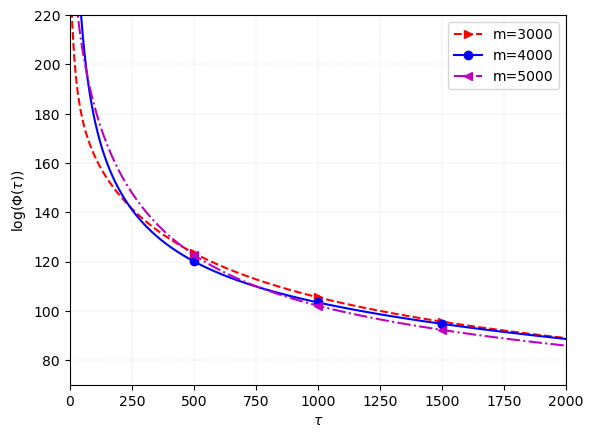

In [36]:
plt.figure(1)
plt.plot(range(epochs), loss_plot3000,'r--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot4000,'b-',marker='o',markevery=500)
plt.plot(range(epochs), loss_plot5000,'m-.',marker='<',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['m=3000','m=4000','m=5000'])
plt.axis([0,2000,70,220])
plt.savefig('code_DEM_MNIST_new.pdf') 
plt.savefig('code_DEM_MNIST_new.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)



In [13]:
class NetReLU(nn.Module):
    def __init__(self, width, Wstd):
        super(NetReLU, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply ReLU to the sum of weighted input and bias, then scale
        y = F.relu(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [14]:
def setup_and_train_ReLU(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetReLU(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [15]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000ReLU = setup_and_train_ReLU(epochs, lr, 3000, Wstd)


/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.62s | loss 939.25 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.74s | loss 585.14 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.58s | loss 464.10 
lambda_min tensor(0.0034+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.46s | loss 416.56 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.52s | loss 392.66 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.65s | loss 188.78 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.67s | loss 187.60 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.64s | loss 186.47 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.69s | loss 185.38 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  8.85s | loss 184.33 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.78s | loss 183.33 
lambda_min tensor(0.0029+0.j, grad_fn

lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.03s | loss 159.77 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.81s | loss 159.47 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.94s | loss 159.17 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.81s | loss 158.88 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.89s | loss 158.60 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.95s | loss 148.86 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.95s | loss 148.68 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.84s | loss 148.51 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.87s | loss 148.33 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.93s | loss 148.15 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8.89s | loss 147.98 
lambda_min tensor(0.0031+0.j, grad_fn

lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  9.33s | loss 141.21 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.74s | loss 141.07 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.85s | loss 140.93 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  8.83s | loss 140.80 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.83s | loss 140.66 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.89s | loss 135.20 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.90s | loss 135.09 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.88s | loss 134.98 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.90s | loss 134.86 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.92s | loss 134.75 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8.94s | loss 134.64 
lambda_min tensor(0.0026+0.j, grad_fn

lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.87s | loss 130.08 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  8.92s | loss 129.98 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.86s | loss 129.89 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  8.95s | loss 129.79 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  9.00s | loss 129.70 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.91s | loss 125.77 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  8.81s | loss 125.69 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.01s | loss 125.60 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.96s | loss 125.52 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.90s | loss 125.44 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.89s | loss 125.36 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.98s | loss 121.93 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.94s | loss 121.86 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.85s | loss 121.78 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.06s | loss 121.71 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.89s | loss 121.64 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.93s | loss 118.59 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.88s | loss 118.53 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.91s | loss 118.46 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.87s | loss 118.40 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.77s | loss 118.33 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8.89s | loss 118.27 
lambda_min tensor(0.0032+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.80s | loss 115.56 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.82s | loss 115.50 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.85s | loss 115.44 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.93s | loss 115.38 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.98s | loss 115.33 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.84s | loss 112.89 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.88s | loss 112.83 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.93s | loss 112.78 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.99s | loss 112.73 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.90s | loss 112.68 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8.85s | loss 112.62 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.79s | loss 110.42 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.88s | loss 110.37 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.89s | loss 110.33 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.86s | loss 110.28 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.83s | loss 110.23 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.95s | loss 108.22 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  9.03s | loss 108.18 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.89s | loss 108.14 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  8.95s | loss 108.09 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.95s | loss 108.05 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  9.09s | loss 108.01 
lambda_min tensor(0.0031+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.97s | loss 106.17 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.19s | loss 106.13 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.88s | loss 106.09 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.79s | loss 106.05 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.85s | loss 106.01 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.91s | loss 104.33 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.84s | loss 104.29 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.93s | loss 104.25 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  9.41s | loss 104.21 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.90s | loss 104.18 
lambda_min tensor(0.0041+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.84s | loss 104.14 
lambda_min tensor(0.0026+0.j, grad_fn

lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.91s | loss 102.59 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.84s | loss 102.55 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.97s | loss 102.52 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.86s | loss 102.48 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  9.44s | loss 102.45 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  8.92s | loss 101.01 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.85s | loss 100.97 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.92s | loss 100.94 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.95s | loss 100.91 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.92s | loss 100.88 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8.96s | loss 100.85 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.90s | loss 99.50 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.93s | loss 99.47 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.90s | loss 99.44 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.85s | loss 99.41 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  8.94s | loss 99.38 
lambda_min tensor(0.0039+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  9.00s 

lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.92s | loss 98.09 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.92s | loss 98.06 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.93s | loss 98.03 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.94s | loss 98.00 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.94s | loss 97.98 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 928 | time / epoch  9.24s 

lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  8.83s | loss 96.77 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  9.04s | loss 96.74 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.07s | loss 96.72 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  8.87s | loss 96.69 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  8.87s | loss 96.66 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 977 | time / epoch  8.90s 

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  8.92s | loss 95.52 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.89s | loss 95.49 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  8.89s | loss 95.47 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  8.90s | loss 95.44 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1025 | time / epoch  8.88s | loss 95.42 
lambda_min tensor(0.0036+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1026 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.87s | loss 94.36 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.94s | loss 94.34 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  8.82s | loss 94.32 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.93s | loss 94.29 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1073 | time / epoch  8.94s | loss 94.27 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1074 | time / epoch  8.86s | loss 94.24 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.91s | loss 93.24 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.86s | loss 93.22 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.87s | loss 93.20 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1121 | time / epoch  8.88s | loss 93.17 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1122 | time / epoch  9.00s | loss 93.15 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1123 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.94s | loss 92.20 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.86s | loss 92.18 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.93s | loss 92.16 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1169 | time / epoch  8.88s | loss 92.14 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1170 | time / epoch  8.94s | loss 92.12 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1171 | time / epoch  8.99s | loss 92.09 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.91s | loss 91.19 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.86s | loss 91.17 
lambda_min tensor(0.0025+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1217 | time / epoch  8.95s | loss 91.15 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1218 | time / epoch  8.90s | loss 91.13 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1219 | time / epoch  8.92s | loss 91.11 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1220 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.87s | loss 90.24 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.85s | loss 90.22 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1265 | time / epoch  8.93s | loss 90.20 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1266 | time / epoch  8.86s | loss 90.18 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1267 | time / epoch  8.85s | loss 90.16 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1268 | time / epoch  8.92s | loss 90.14 
lambda_min tensor(0.0031+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.99s | loss 89.31 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1313 | time / epoch  9.02s | loss 89.29 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1314 | time / epoch  8.92s | loss 89.27 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1315 | time / epoch  8.99s | loss 89.25 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1316 | time / epoch  8.94s | loss 89.24 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1317 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.87s | loss 88.44 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1361 | time / epoch  8.87s | loss 88.42 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1362 | time / epoch  8.95s | loss 88.41 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1363 | time / epoch  8.93s | loss 88.39 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1364 | time / epoch  8.92s | loss 88.37 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1365 | time / epoch  8.95s | loss 88.35 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1409 | time / epoch  9.92s | loss 87.59 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1410 | time / epoch 10.35s | loss 87.58 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1411 | time / epoch 10.68s | loss 87.56 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1412 | time / epoch  9.69s | loss 87.54 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1413 | time / epoch  9.73s | loss 87.53 
lambda_min tensor(0.0025+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1414 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1457 | time / epoch  9.47s | loss 86.80 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1458 | time / epoch  9.40s | loss 86.78 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1459 | time / epoch 10.53s | loss 86.77 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1460 | time / epoch  9.46s | loss 86.75 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1461 | time / epoch  9.62s | loss 86.73 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1462 | time / epoch  9.40s | loss 86.72 
lambda_min tensor(0.0031+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1506 | time / epoch  8.76s | loss 86.01 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1507 | time / epoch  8.64s | loss 86.00 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1508 | time / epoch  9.20s | loss 85.98 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1509 | time / epoch  8.71s | loss 85.97 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1510 | time / epoch  8.80s | loss 85.95 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1511 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1554 | time / epoch  8.69s | loss 85.27 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1555 | time / epoch  8.67s | loss 85.25 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1556 | time / epoch  8.77s | loss 85.24 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1557 | time / epoch  8.75s | loss 85.22 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1558 | time / epoch  8.73s | loss 85.21 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1559 | time / epoch  8.67s | loss 85.19 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1603 | time / epoch  9.35s | loss 84.53 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1604 | time / epoch  8.75s | loss 84.52 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1605 | time / epoch  8.70s | loss 84.51 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1606 | time / epoch  8.71s | loss 84.49 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1607 | time / epoch  8.75s | loss 84.48 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1608 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1651 | time / epoch  8.76s | loss 83.84 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1652 | time / epoch  8.75s | loss 83.82 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1653 | time / epoch  8.71s | loss 83.81 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1654 | time / epoch  8.78s | loss 83.79 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch  8.71s | loss 83.78 
lambda_min tensor(0.0036+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1656 | time / epoch  8.68s | loss 83.77 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1700 | time / epoch  8.72s | loss 83.15 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1701 | time / epoch  8.73s | loss 83.14 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch  9.27s | loss 83.12 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch  8.74s | loss 83.11 
lambda_min tensor(0.0030-1.7529e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch  8.78s | loss 83.09 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1705 | time /

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1748 | time / epoch  8.73s | loss 82.49 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1749 | time / epoch  8.69s | loss 82.48 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch  8.66s | loss 82.47 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch  8.68s | loss 82.45 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch  8.75s | loss 82.44 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1753 | time / epoch  8.71s | loss 82.43 
lambda_min tensor(0.0027+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch  8.70s | loss 81.84 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch  8.73s | loss 81.83 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch  8.73s | loss 81.82 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch  8.70s | loss 81.80 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch  8.72s | loss 81.79 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1802 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1845 | time / epoch  8.72s | loss 81.22 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch  8.73s | loss 81.21 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch  8.69s | loss 81.19 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch  8.68s | loss 81.18 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch  8.70s | loss 81.17 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1850 | time / epoch  8.74s | loss 81.15 
lambda_min tensor(0.0026+0.j, grad_fn

lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch  8.74s | loss 80.60 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch  8.73s | loss 80.59 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch  8.72s | loss 80.58 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch  8.75s | loss 80.56 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch  8.75s | loss 80.55 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1899 | time / epoch  

singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch  8.67s | loss 80.01 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch  8.85s | loss 80.00 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch  8.69s | loss 79.98 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch  8.72s | loss 79.97 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch  8.72s | loss 79.96 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1947 | time / epoch  8.78s | loss 79.95 
lambda_min tensor(0.0029+0.j, grad_fn

lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch  8.70s | loss 79.42 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch  8.75s | loss 79.40 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch  8.69s | loss 79.39 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1994 | time / epoch  8.73s | loss 79.38 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1995 | time / epoch  8.77s | loss 79.37 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7983+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1996 | time / epoch  

In [16]:
class NetSIN(nn.Module):
    def __init__(self, width, Wstd):
        super(NetSIN, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply ReLU to the sum of weighted input and bias, then scale
        y = torch.sin(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [17]:
def setup_and_train_SIN(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetSIN(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [18]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000sin=setup_and_train_SIN(epochs, lr, 3000, Wstd)

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.63s | loss 1272.97 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.58s | loss 566.68 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.67s | loss 353.37 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.71s | loss 288.02 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.64s | loss 267.11 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.73s | loss 206.51 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.88s | loss 205.73 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.90s | loss 204.96 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.88s | loss 204.20 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.46s | loss 203.45 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  8.80s | loss 202.70 
lambda_min tensor(0.0028+0.j, grad_fn

| end of epoch  97 | time / epoch  9.42s | loss 178.01 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7978+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.03s | loss 177.56 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  8.82s | loss 177.11 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.86s | loss 176.67 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  8.74s | loss 176.23 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  8.71s | loss 175.80 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  8.79s | loss 159.99 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.86s | loss 159.69 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  8.93s | loss 159.39 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  8.88s | loss 159.10 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  8.82s | loss 158.81 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 194 | time / epoch  8.66s | loss 147.82 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  8.63s | loss 147.61 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.86s | loss 147.39 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  8.89s | loss 147.18 
lambda_min tensor(0.0025+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.00s | loss 146.97 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.90s | loss 146.76 
lambda_min tensor(0.0034+0.j, grad_fn

lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  8.93s | loss 138.76 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  8.81s | loss 138.60 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  8.84s | loss 138.45 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  8.82s | loss 138.29 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  8.74s | loss 138.13 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 291 | time / epoch  8.79s | loss 132.05 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  8.78s | loss 131.92 
lambda_min tensor(0.0035+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  8.87s | loss 131.80 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  8.82s | loss 131.68 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  8.71s | loss 131.56 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  8.69s | loss 131.44 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  8.77s | loss 126.69 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  8.84s | loss 126.59 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  8.80s | loss 126.50 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  8.89s | loss 126.40 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  8.65s | loss 126.30 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 388 | time / epoch  8.68s | loss 122.47 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  8.81s | loss 122.39 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  8.82s | loss 122.31 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.82s | loss 122.23 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  8.82s | loss 122.16 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  8.84s | loss 122.08 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  8.78s | loss 118.92 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  8.69s | loss 118.85 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  8.80s | loss 118.78 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  8.81s | loss 118.72 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  8.91s | loss 118.65 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 485 | time / epoch  8.90s | loss 115.98 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  8.88s | loss 115.92 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  8.83s | loss 115.86 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  8.69s | loss 115.81 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  8.73s | loss 115.75 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  8.64s | loss 115.69 
lambda_min tensor(0.0031+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.79s | loss 113.39 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  8.86s | loss 113.34 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  8.89s | loss 113.29 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  9.02s | loss 113.24 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  8.84s | loss 113.19 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 582 | time / epoch  8.98s | loss 111.16 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  8.87s | loss 111.11 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  8.92s | loss 111.07 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  8.94s | loss 111.03 
lambda_min tensor(0.0025+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  8.81s | loss 110.98 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  8.82s | loss 110.94 
lambda_min tensor(0.0029+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  8.74s | loss 109.13 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  8.78s | loss 109.09 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  8.69s | loss 109.05 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  8.94s | loss 109.01 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  8.77s | loss 108.97 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 679 | time / epoch  8.78s | loss 107.34 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.88s | loss 107.30 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  8.76s | loss 107.27 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  9.15s | loss 107.23 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.87s | loss 107.20 
lambda_min tensor(0.0035+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  8.75s | loss 107.16 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  8.77s | loss 105.67 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  8.74s | loss 105.63 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  8.75s | loss 105.60 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.70s | loss 105.57 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.79s | loss 105.54 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 776 | time / epoch  8.82s | loss 104.16 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  8.80s | loss 104.13 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.92s | loss 104.10 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  8.87s | loss 104.07 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  8.74s | loss 104.04 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  8.94s | loss 104.01 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  9.37s | loss 102.73 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.81s | loss 102.70 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.81s | loss 102.67 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.83s | loss 102.64 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  8.87s | loss 102.62 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  8

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 873 | time / epoch  8.80s | loss 101.42 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  8.81s | loss 101.40 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  8.90s | loss 101.37 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.73s | loss 101.34 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  8.68s | loss 101.32 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  9.00s | loss 101.29 
lambda_min tensor(0.0029+0.j, grad_fn

lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  8.68s | loss 100.17 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  8.86s | loss 100.14 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.80s | loss 100.12 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  9.12s | loss 100.09 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.76s | loss 100.07 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  8.80s | loss 98.99 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  8.90s | loss 98.97 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.79s | loss 98.94 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  8.83s | loss 98.92 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.26s | loss 98.90 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  8.87s 

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  8.80s | loss 97.87 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  8.92s | loss 97.85 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  8.88s | loss 97.83 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  8.77s | loss 97.81 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  8.79s | loss 97.78 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1025 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  8.93s | loss 96.83 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  8.72s | loss 96.81 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  8.82s | loss 96.79 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  9.33s | loss 96.77 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  8.77s | loss 96.75 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1073 | time / epoch  8.89s | loss 96.73 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  8.81s | loss 95.82 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.79s | loss 95.80 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.82s | loss 95.78 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.85s | loss 95.76 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1121 | time / epoch  8.83s | loss 95.74 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1122 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.81s | loss 94.88 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.72s | loss 94.86 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.87s | loss 94.84 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.66s | loss 94.82 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1169 | time / epoch  8.80s | loss 94.80 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1170 | time / epoch  8.89s | loss 94.78 
lambda_min tensor(0.0029+0.j, grad_fn

lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  8.87s | loss 93.95 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.83s | loss 93.93 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.82s | loss 93.91 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1217 | time / epoch  8.80s | loss 93.90 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1218 | time / epoch  8.65s | loss 93.88 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1219 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  8.77s | loss 93.08 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.81s | loss 93.07 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.81s | loss 93.05 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1265 | time / epoch  8.82s | loss 93.03 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1266 | time / epoch  8.93s | loss 93.01 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1267 | time / epoch  8.84s | loss 92.99 
lambda_min tensor(0.0028+0.j, grad_fn

lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  8.60s | loss 92.23 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.82s | loss 92.21 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1313 | time / epoch  8.83s | loss 92.20 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1314 | time / epoch  8.79s | loss 92.18 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1315 | time / epoch  8.67s | loss 92.16 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1316 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  8.84s | loss 91.43 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.68s | loss 91.41 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1361 | time / epoch  8.73s | loss 91.39 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1362 | time / epoch  8.87s | loss 91.38 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1363 | time / epoch  8.68s | loss 91.36 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1364 | time / epoch  8.54s | loss 91.35 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  8.80s | loss 90.64 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1409 | time / epoch  8.80s | loss 90.62 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1410 | time / epoch  8.86s | loss 90.60 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1411 | time / epoch  8.83s | loss 90.59 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1412 | time / epoch  8.72s | loss 90.57 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1413 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.73s | loss 89.89 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1457 | time / epoch  8.85s | loss 89.87 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1458 | time / epoch  8.82s | loss 89.86 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1459 | time / epoch  9.10s | loss 89.84 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1460 | time / epoch  9.10s | loss 89.83 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1461 | time / epoch  8.89s | loss 89.81 
lambda_min tensor(0.0026+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1505 | time / epoch  8.73s | loss 89.15 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1506 | time / epoch  8.74s | loss 89.13 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1507 | time / epoch  8.76s | loss 89.12 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1508 | time / epoch  8.61s | loss 89.10 
lambda_min tensor(0.0025+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1509 | time / epoch  8.65s | loss 89.09 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1510 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1553 | time / epoch  8.83s | loss 88.45 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1554 | time / epoch  8.91s | loss 88.43 
lambda_min tensor(0.0034+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1555 | time / epoch  8.85s | loss 88.42 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1556 | time / epoch  8.86s | loss 88.40 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1557 | time / epoch  8.78s | loss 88.39 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1558 | time / epoch  8.67s | loss 88.38 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1602 | time / epoch  8.86s | loss 87.75 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1603 | time / epoch  8.87s | loss 87.74 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1604 | time / epoch  8.94s | loss 87.73 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1605 | time / epoch  8.77s | loss 87.71 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1606 | time / epoch  8.80s | loss 87.70 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1607 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1650 | time / epoch  8.72s | loss 87.09 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1651 | time / epoch  9.16s | loss 87.08 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1652 | time / epoch  8.80s | loss 87.07 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1653 | time / epoch  8.80s | loss 87.05 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1654 | time / epoch  8.81s | loss 87.04 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1655 | time / epoch  8.85s | loss 87.03 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1699 | time / epoch  8.91s | loss 86.44 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1700 | time / epoch  8.80s | loss 86.43 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1701 | time / epoch  8.75s | loss 86.41 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1702 | time / epoch  9.03s | loss 86.40 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1703 | time / epoch  8.79s | loss 86.39 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1704 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1747 | time / epoch  8.98s | loss 85.82 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1748 | time / epoch  8.87s | loss 85.80 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1749 | time / epoch  8.88s | loss 85.79 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1750 | time / epoch  8.70s | loss 85.78 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1751 | time / epoch  8.73s | loss 85.77 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1752 | time / epoch  8.83s | loss 85.75 
lambda_min tensor(0.0033+0.j, grad_fn

lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1796 | time / epoch  8.73s | loss 85.20 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1797 | time / epoch  8.95s | loss 85.19 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1798 | time / epoch  8.75s | loss 85.17 
lambda_min tensor(0.0032+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1799 | time / epoch  8.83s | loss 85.16 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1800 | time / epoch  9.15s | loss 85.15 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1801 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1844 | time / epoch  8.82s | loss 84.61 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1845 | time / epoch  8.81s | loss 84.60 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1846 | time / epoch  8.75s | loss 84.58 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1847 | time / epoch  8.89s | loss 84.57 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1848 | time / epoch  8.72s | loss 84.56 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1849 | time / epoch  8.68s | loss 84.55 
lambda_min tensor(0.0030+0.j, grad_fn

lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1893 | time / epoch  8.94s | loss 84.02 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1894 | time / epoch  8.56s | loss 84.01 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1895 | time / epoch  8.73s | loss 84.00 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1896 | time / epoch  8.80s | loss 83.98 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1897 | time / epoch  8.90s | loss 83.97 
lambda_min tensor(0.0035+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1898 | time / epoch  

singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1941 | time / epoch  8.93s | loss 83.46 
lambda_min tensor(0.0027+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1942 | time / epoch  8.81s | loss 83.45 
lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1943 | time / epoch  8.74s | loss 83.44 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1944 | time / epoch  8.92s | loss 83.42 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1945 | time / epoch  8.86s | loss 83.41 
lambda_min tensor(0.0033+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1946 | time / epoch  8.78s | loss 83.40 
lambda_min tensor(0.0033+0.j, grad_fn

lambda_min tensor(0.0026+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1990 | time / epoch  8.69s | loss 82.90 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1991 | time / epoch  8.74s | loss 82.89 
lambda_min tensor(0.0031+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1992 | time / epoch  8.88s | loss 82.88 
lambda_min tensor(0.0030+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1993 | time / epoch  8.72s | loss 82.86 
lambda_min tensor(0.0028+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1994 | time / epoch  8.61s | loss 82.85 
lambda_min tensor(0.0029+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7979+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1995 | time / epoch  

In [19]:
# Identity activation
class NetIDENTITY(nn.Module):
    def __init__(self, width, Wstd):
        super(NetIDENTITY, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply sin to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [20]:
def setup_and_train_IDENTITY(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetIDENTITY(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [21]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000identity=setup_and_train_IDENTITY(epochs, lr, 3000, Wstd)

lambda_min tensor(1.0868e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.92s | loss 1382.53 
lambda_min tensor(9.9483e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.85s | loss 662.08 
lambda_min tensor(-1.2978e-07-6.1339e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.91s | loss 618.18 
lambda_min tensor(5.6438e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.99s | loss 582.58 
lambda_min tensor(-1.2066e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.98s | loss 553.00 
lambda_min tensor(-3.0093e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)


lambda_min tensor(1.4228e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  48 | time / epoch  9.07s | loss 271.84 
lambda_min tensor(1.3277e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  8.95s | loss 269.79 
lambda_min tensor(1.3182e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.93s | loss 267.79 
lambda_min tensor(-1.0031e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.99s | loss 265.85 
lambda_min tensor(1.3010e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.07s | loss 263.95 
lambda_min tensor(-1.1154e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(-3.7665e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  95 | time / epoch  9.14s | loss 211.54 
lambda_min tensor(9.2256e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  96 | time / epoch  9.19s | loss 210.74 
lambda_min tensor(-5.9190e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  97 | time / epoch  9.08s | loss 209.96 
lambda_min tensor(-6.1025e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.18s | loss 209.18 
lambda_min tensor(1.1548e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.06s | loss 208.42 
lambda_min tensor(9.3967e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of 

lambda_min tensor(4.4488e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 142 | time / epoch  9.20s | loss 183.75 
lambda_min tensor(-1.0977e-06-2.5007e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 143 | time / epoch  9.12s | loss 183.32 
lambda_min tensor(1.0662e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 144 | time / epoch  9.05s | loss 182.89 
lambda_min tensor(2.0655e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 145 | time / epoch  9.06s | loss 182.47 
lambda_min tensor(4.3034e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  9.15s | loss 182.06 
lambda_min tensor(8.9881e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| e

lambda_min tensor(9.0358e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 189 | time / epoch  9.61s | loss 167.73 
lambda_min tensor(7.6268e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 190 | time / epoch  9.15s | loss 167.46 
lambda_min tensor(-7.0328e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 191 | time / epoch  9.20s | loss 167.20 
lambda_min tensor(-1.2879e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 192 | time / epoch  9.10s | loss 166.94 
lambda_min tensor(-5.4529e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 193 | time / epoch  9.13s | loss 166.68 
lambda_min tensor(-8.4875e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of

lambda_min tensor(4.5972e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 236 | time / epoch  9.11s | loss 157.27 
lambda_min tensor(-6.7061e-08-2.6642e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 237 | time / epoch  9.16s | loss 157.09 
lambda_min tensor(1.9602e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 238 | time / epoch  9.13s | loss 156.90 
lambda_min tensor(1.8547e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 239 | time / epoch  9.24s | loss 156.72 
lambda_min tensor(4.0600e-08-1.6776e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 240 | time / epoch  9.11s | loss 156.54 
lambda_min tensor(5.9232e-07-6.6436e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<Sqr

lambda_min tensor(1.1855e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 283 | time / epoch  9.07s | loss 149.73 
lambda_min tensor(1.0763e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 284 | time / epoch  9.17s | loss 149.59 
lambda_min tensor(1.6614e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 285 | time / epoch  9.09s | loss 149.45 
lambda_min tensor(8.6684e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 286 | time / epoch  9.16s | loss 149.31 
lambda_min tensor(1.6768e-06-1.5837e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 287 | time / epoch  9.23s | loss 149.18 
lambda_min tensor(1.5617e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(3.5031e-07-1.9733e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 330 | time / epoch  9.24s | loss 143.85 
lambda_min tensor(1.5165e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 331 | time / epoch  9.04s | loss 143.74 
lambda_min tensor(1.8429e-06-6.6810e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 332 | time / epoch  9.07s | loss 143.63 
lambda_min tensor(9.5025e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 333 | time / epoch  9.20s | loss 143.52 
lambda_min tensor(1.5203e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 334 | time / epoch  9.19s | loss 143.41 
lambda_min tensor(7.0522e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward

lambda_min tensor(-3.4001e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 377 | time / epoch  9.08s | loss 139.02 
lambda_min tensor(-4.0377e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 378 | time / epoch  9.21s | loss 138.92 
lambda_min tensor(8.4654e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 379 | time / epoch  9.07s | loss 138.83 
lambda_min tensor(1.3600e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 380 | time / epoch  9.08s | loss 138.73 
lambda_min tensor(-1.5077e-05+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 381 | time / epoch  9.17s | loss 138.64 
lambda_min tensor(1.3220e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of 

lambda_min tensor(-6.6932e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 424 | time / epoch  9.14s | loss 134.89 
lambda_min tensor(2.9549e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 425 | time / epoch  9.10s | loss 134.81 
lambda_min tensor(1.9324e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 426 | time / epoch  9.08s | loss 134.73 
lambda_min tensor(5.0125e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 427 | time / epoch  9.07s | loss 134.64 
lambda_min tensor(3.5105e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 428 | time / epoch  9.18s | loss 134.56 
lambda_min tensor(-1.2792e-06-8.9993e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(-3.3011e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 471 | time / epoch  9.17s | loss 131.28 
lambda_min tensor(1.7694e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 472 | time / epoch  9.16s | loss 131.21 
lambda_min tensor(9.9861e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 473 | time / epoch  8.98s | loss 131.14 
lambda_min tensor(1.0785e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 474 | time / epoch  9.00s | loss 131.07 
lambda_min tensor(5.2322e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 475 | time / epoch  9.11s | loss 130.99 
lambda_min tensor(1.1398e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of ep

lambda_min tensor(9.4801e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 518 | time / epoch  9.02s | loss 128.08 
lambda_min tensor(5.1281e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 519 | time / epoch  9.21s | loss 128.01 
lambda_min tensor(1.2416e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 520 | time / epoch  9.15s | loss 127.95 
lambda_min tensor(5.7585e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 521 | time / epoch  9.16s | loss 127.89 
lambda_min tensor(6.3270e-07-1.4063e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 522 | time / epoch  9.18s | loss 127.82 
lambda_min tensor(1.3290e-06-4.3789e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward

lambda_min tensor(1.2416e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 565 | time / epoch  8.56s | loss 125.20 
lambda_min tensor(-3.9406e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 566 | time / epoch  9.38s | loss 125.15 
lambda_min tensor(7.0830e-07-2.7806e-09j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 567 | time / epoch  9.32s | loss 125.09 
lambda_min tensor(1.4624e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 568 | time / epoch  8.73s | loss 125.03 
lambda_min tensor(9.0584e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 569 | time / epoch  8.82s | loss 124.97 
lambda_min tensor(8.9962e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| e

lambda_min tensor(3.7895e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 612 | time / epoch  9.29s | loss 122.60 
lambda_min tensor(1.8006e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 613 | time / epoch  8.88s | loss 122.55 
lambda_min tensor(7.2116e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 614 | time / epoch  9.22s | loss 122.50 
lambda_min tensor(3.9919e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 615 | time / epoch  9.79s | loss 122.44 
lambda_min tensor(4.8855e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 616 | time / epoch  8.98s | loss 122.39 
lambda_min tensor(-5.9310e-09+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of ep

lambda_min tensor(7.8540e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 659 | time / epoch  9.23s | loss 120.23 
lambda_min tensor(6.0557e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 660 | time / epoch  9.19s | loss 120.19 
lambda_min tensor(4.6922e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 661 | time / epoch  9.08s | loss 120.14 
lambda_min tensor(1.6610e-06-1.8127e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 662 | time / epoch  9.16s | loss 120.09 
lambda_min tensor(2.8540e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 663 | time / epoch  9.16s | loss 120.04 
lambda_min tensor(7.3996e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(1.0802e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 706 | time / epoch  9.07s | loss 118.06 
lambda_min tensor(1.5117e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 707 | time / epoch  9.25s | loss 118.02 
lambda_min tensor(-1.5470e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 708 | time / epoch  9.14s | loss 117.98 
lambda_min tensor(-9.0130e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 709 | time / epoch  9.08s | loss 117.93 
lambda_min tensor(-2.0924e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 710 | time / epoch  9.57s | loss 117.89 
lambda_min tensor(3.0060e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of 

lambda_min tensor(1.9165e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 753 | time / epoch  9.12s | loss 116.07 
lambda_min tensor(-1.6696e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 754 | time / epoch  9.02s | loss 116.03 
lambda_min tensor(-7.0958e-07-1.9296e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 755 | time / epoch  9.22s | loss 115.99 
lambda_min tensor(3.0224e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 756 | time / epoch  9.04s | loss 115.95 
lambda_min tensor(9.7249e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 757 | time / epoch  9.08s | loss 115.91 
lambda_min tensor(9.3654e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(9.1274e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 800 | time / epoch  8.74s | loss 114.23 
lambda_min tensor(4.5231e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 801 | time / epoch  9.04s | loss 114.19 
lambda_min tensor(7.7532e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 802 | time / epoch  8.71s | loss 114.16 
lambda_min tensor(8.6649e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 803 | time / epoch  8.81s | loss 114.12 
lambda_min tensor(2.0687e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 804 | time / epoch  9.03s | loss 114.08 
lambda_min tensor(1.4959e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(1.3018e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 847 | time / epoch  9.15s | loss 112.53 
lambda_min tensor(-8.8043e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 848 | time / epoch  9.18s | loss 112.49 
lambda_min tensor(-7.7130e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 849 | time / epoch  8.88s | loss 112.46 
lambda_min tensor(8.9734e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 850 | time / epoch  9.07s | loss 112.42 
lambda_min tensor(1.9084e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 851 | time / epoch  9.22s | loss 112.39 
lambda_min tensor(1.2875e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(1.3662e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 894 | time / epoch  9.17s | loss 110.94 
lambda_min tensor(-7.0205e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 895 | time / epoch  9.18s | loss 110.91 
lambda_min tensor(3.8393e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 896 | time / epoch  8.92s | loss 110.88 
lambda_min tensor(2.2914e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 897 | time / epoch  9.05s | loss 110.85 
lambda_min tensor(6.3478e-09+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 898 | time / epoch  9.13s | loss 110.81 
lambda_min tensor(7.1196e-07-6.3232e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| e

lambda_min tensor(7.9856e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 941 | time / epoch  8.90s | loss 109.47 
lambda_min tensor(1.7963e-06-4.9866e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 942 | time / epoch  9.11s | loss 109.44 
lambda_min tensor(1.3991e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 943 | time / epoch  9.19s | loss 109.41 
lambda_min tensor(-7.1449e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 944 | time / epoch  9.24s | loss 109.38 
lambda_min tensor(6.3397e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 945 | time / epoch  9.04s | loss 109.35 
lambda_min tensor(-2.5516e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(8.1258e-07-1.3222e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 988 | time / epoch  8.88s | loss 108.09 
lambda_min tensor(-1.0985e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 989 | time / epoch  9.14s | loss 108.06 
lambda_min tensor(-1.8620e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 990 | time / epoch  9.13s | loss 108.03 
lambda_min tensor(-3.2005e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 991 | time / epoch  9.18s | loss 108.00 
lambda_min tensor(1.0324e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 992 | time / epoch  9.13s | loss 107.98 
lambda_min tensor(9.1390e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
|

lambda_min tensor(1.2365e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1035 | time / epoch  9.00s | loss 106.80 
lambda_min tensor(-1.4133e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1036 | time / epoch  9.04s | loss 106.77 
lambda_min tensor(8.6809e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1037 | time / epoch  8.83s | loss 106.75 
lambda_min tensor(-1.5801e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1038 | time / epoch  9.15s | loss 106.72 
lambda_min tensor(-8.5575e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1039 | time / epoch  8.96s | loss 106.69 
lambda_min tensor(1.1927e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| en

lambda_min tensor(1.1028e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1082 | time / epoch  9.04s | loss 105.59 
lambda_min tensor(6.0337e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1083 | time / epoch  8.86s | loss 105.56 
lambda_min tensor(9.4717e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1084 | time / epoch  9.03s | loss 105.54 
lambda_min tensor(1.3317e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1085 | time / epoch  9.05s | loss 105.51 
lambda_min tensor(7.4341e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1086 | time / epoch  8.92s | loss 105.49 
lambda_min tensor(-1.9292e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end 

lambda_min tensor(-2.4725e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1129 | time / epoch  9.03s | loss 104.45 
lambda_min tensor(1.4701e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1130 | time / epoch  8.96s | loss 104.42 
lambda_min tensor(1.7386e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1131 | time / epoch  8.95s | loss 104.40 
lambda_min tensor(1.1637e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1132 | time / epoch  8.99s | loss 104.38 
lambda_min tensor(1.2382e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1133 | time / epoch  8.89s | loss 104.35 
lambda_min tensor(6.0406e-07-8.1481e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>

lambda_min tensor(8.0013e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1176 | time / epoch  9.05s | loss 103.37 
lambda_min tensor(7.8358e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1177 | time / epoch  8.92s | loss 103.35 
lambda_min tensor(1.1637e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1178 | time / epoch  8.90s | loss 103.33 
lambda_min tensor(-1.4371e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1179 | time / epoch  9.05s | loss 103.31 
lambda_min tensor(4.3894e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1180 | time / epoch  9.09s | loss 103.28 
lambda_min tensor(-4.2223e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end

lambda_min tensor(4.9618e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1223 | time / epoch  8.94s | loss 102.36 
lambda_min tensor(7.4934e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1224 | time / epoch  8.94s | loss 102.33 
lambda_min tensor(7.4980e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1225 | time / epoch  8.97s | loss 102.31 
lambda_min tensor(-9.4232e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1226 | time / epoch  9.01s | loss 102.29 
lambda_min tensor(-4.8196e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1227 | time / epoch  9.06s | loss 102.27 
lambda_min tensor(1.3042e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end

lambda_min tensor(-2.4872e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1270 | time / epoch  9.03s | loss 101.39 
lambda_min tensor(1.1472e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1271 | time / epoch  9.11s | loss 101.37 
lambda_min tensor(-4.1985e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1272 | time / epoch  9.13s | loss 101.35 
lambda_min tensor(1.0401e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1273 | time / epoch  9.05s | loss 101.33 
lambda_min tensor(2.2877e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1274 | time / epoch  8.87s | loss 101.31 
lambda_min tensor(4.9592e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end

lambda_min tensor(-2.1786e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1317 | time / epoch  9.21s | loss 100.48 
lambda_min tensor(1.3772e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1318 | time / epoch  8.81s | loss 100.46 
lambda_min tensor(7.9053e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1319 | time / epoch  8.80s | loss 100.44 
lambda_min tensor(-7.9745e-07-8.3351e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1320 | time / epoch  9.04s | loss 100.43 
lambda_min tensor(5.5212e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1321 | time / epoch  8.89s | loss 100.41 
lambda_min tensor(-3.7584e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward

lambda_min tensor(-1.0875e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1364 | time / epoch  9.15s | loss 99.62 
lambda_min tensor(-9.8936e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1365 | time / epoch  8.89s | loss 99.60 
lambda_min tensor(1.3456e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1366 | time / epoch  9.11s | loss 99.58 
lambda_min tensor(4.1083e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1367 | time / epoch  9.01s | loss 99.56 
lambda_min tensor(1.2373e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1368 | time / epoch  8.93s | loss 99.54 
lambda_min tensor(1.1952e-06-2.6608e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(1.4792e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1411 | time / epoch  8.99s | loss 98.79 
lambda_min tensor(7.5148e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1412 | time / epoch  9.04s | loss 98.77 
lambda_min tensor(-1.7547e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1413 | time / epoch  9.04s | loss 98.76 
lambda_min tensor(1.3641e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1414 | time / epoch  8.98s | loss 98.74 
lambda_min tensor(4.7408e-08+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1415 | time / epoch  8.96s | loss 98.72 
lambda_min tensor(-9.9746e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(-1.5186e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1458 | time / epoch  9.13s | loss 98.01 
lambda_min tensor(2.5462e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1459 | time / epoch  8.95s | loss 97.99 
lambda_min tensor(-8.0111e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1460 | time / epoch  9.04s | loss 97.97 
lambda_min tensor(5.7507e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1461 | time / epoch  9.19s | loss 97.96 
lambda_min tensor(5.1999e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1462 | time / epoch  9.03s | loss 97.94 
lambda_min tensor(9.3125e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(1.4675e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1505 | time / epoch  9.05s | loss 97.26 
lambda_min tensor(5.1860e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1506 | time / epoch  8.96s | loss 97.24 
lambda_min tensor(-1.8836e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1507 | time / epoch  9.08s | loss 97.23 
lambda_min tensor(2.3388e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1508 | time / epoch  8.95s | loss 97.21 
lambda_min tensor(7.2412e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1509 | time / epoch  9.14s | loss 97.19 
lambda_min tensor(-1.3800e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(9.4934e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  9.05s | loss 96.54 
lambda_min tensor(7.8928e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1553 | time / epoch  9.13s | loss 96.53 
lambda_min tensor(-6.2942e-09+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1554 | time / epoch  9.06s | loss 96.51 
lambda_min tensor(3.7265e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1555 | time / epoch  9.02s | loss 96.50 
lambda_min tensor(-8.1421e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1556 | time / epoch  8.93s | loss 96.48 
lambda_min tensor(9.4264e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(1.0067e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  9.09s | loss 95.85 
lambda_min tensor(-5.9648e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  9.04s | loss 95.84 
lambda_min tensor(5.2460e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1601 | time / epoch  8.89s | loss 95.83 
lambda_min tensor(9.4345e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1602 | time / epoch  9.10s | loss 95.81 
lambda_min tensor(4.8080e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1603 | time / epoch  9.06s | loss 95.80 
lambda_min tensor(9.9382e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of ep

lambda_min tensor(-1.0215e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  9.23s | loss 95.20 
lambda_min tensor(-6.4308e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  9.17s | loss 95.18 
lambda_min tensor(-5.2803e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  9.27s | loss 95.17 
lambda_min tensor(-1.9752e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1649 | time / epoch  9.11s | loss 95.16 
lambda_min tensor(1.2481e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1650 | time / epoch  9.11s | loss 95.14 
lambda_min tensor(-4.1796e-07-6.5806e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)

lambda_min tensor(6.0997e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  9.02s | loss 94.57 
lambda_min tensor(6.5626e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  9.09s | loss 94.55 
lambda_min tensor(6.8336e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  9.24s | loss 94.54 
lambda_min tensor(5.9973e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  9.19s | loss 94.53 
lambda_min tensor(2.0206e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1697 | time / epoch  9.08s | loss 94.52 
lambda_min tensor(-6.0836e-07-3.4698e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| e

lambda_min tensor(5.5728e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1740 | time / epoch  9.03s | loss 93.96 
lambda_min tensor(-5.6685e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  9.18s | loss 93.95 
lambda_min tensor(1.1225e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  9.20s | loss 93.94 
lambda_min tensor(-3.4722e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  9.15s | loss 93.92 
lambda_min tensor(1.9904e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  9.13s | loss 93.91 
lambda_min tensor(-1.3095e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of 

lambda_min tensor(1.0601e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1787 | time / epoch  9.16s | loss 93.38 
lambda_min tensor(1.0043e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1788 | time / epoch  9.05s | loss 93.37 
lambda_min tensor(9.2467e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1789 | time / epoch  9.08s | loss 93.36 
lambda_min tensor(-1.2703e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  9.20s | loss 93.34 
lambda_min tensor(1.1545e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  9.11s | loss 93.33 
lambda_min tensor(-6.1150e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of e

lambda_min tensor(7.0410e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1834 | time / epoch  9.10s | loss 92.82 
lambda_min tensor(1.1125e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1835 | time / epoch  9.20s | loss 92.81 
lambda_min tensor(7.0800e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1836 | time / epoch  9.03s | loss 92.80 
lambda_min tensor(1.0300e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1837 | time / epoch  9.12s | loss 92.79 
lambda_min tensor(1.1948e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  9.19s | loss 92.77 
lambda_min tensor(2.6890e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epo

lambda_min tensor(9.0063e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1881 | time / epoch  9.02s | loss 92.28 
lambda_min tensor(-2.2553e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1882 | time / epoch  9.02s | loss 92.27 
lambda_min tensor(9.1956e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1883 | time / epoch  9.10s | loss 92.26 
lambda_min tensor(2.5396e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1884 | time / epoch  9.11s | loss 92.25 
lambda_min tensor(1.0215e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1885 | time / epoch  9.15s | loss 92.24 
lambda_min tensor(-2.2002e-07-1.8892e-08j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| 

lambda_min tensor(4.7004e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1928 | time / epoch  9.08s | loss 91.76 
lambda_min tensor(1.1301e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1929 | time / epoch  9.12s | loss 91.75 
lambda_min tensor(-6.8076e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1930 | time / epoch  9.14s | loss 91.74 
lambda_min tensor(1.2489e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1931 | time / epoch  9.23s | loss 91.73 
lambda_min tensor(1.2465e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1932 | time / epoch  9.27s | loss 91.72 
lambda_min tensor(9.3254e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of ep

lambda_min tensor(1.1603e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1975 | time / epoch  9.05s | loss 91.26 
lambda_min tensor(6.9119e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1976 | time / epoch  9.15s | loss 91.25 
lambda_min tensor(5.0426e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1977 | time / epoch  9.03s | loss 91.24 
lambda_min tensor(1.2842e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1978 | time / epoch  9.10s | loss 91.23 
lambda_min tensor(-1.0685e-06+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1979 | time / epoch  9.15s | loss 91.22 
lambda_min tensor(2.7664e-07+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7982+0.j, grad_fn=<SqrtBackward0>)
| end of ep

In [22]:
# Swish activation x sigma(x)
class NetSWISH(nn.Module):
    def __init__(self, width, Wstd):
        super(NetSWISH, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply swish to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x)*F.sigmoid(self.wmatrix(z) + x) * math.sqrt(1 / self.width)
        return y

In [23]:
def setup_and_train_SWISH(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetSWISH(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot 

In [24]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000swish=setup_and_train_SWISH(epochs, lr, 3000, Wstd)

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  8.83s | loss 2196.31 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  8.93s | loss 1317.92 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.83s | loss 988.76 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  8.88s | loss 849.98 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  9.49s | loss 778.39 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch 

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  9.03s | loss 238.76 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  8.90s | loss 236.16 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  8.88s | loss 233.69 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  8.95s | loss 231.32 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.00s | loss 229.06 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  9.68s | loss 226.89 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  8.94s | loss 180.27 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.01s | loss 179.76 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  8.96s | loss 179.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  9.02s | loss 178.76 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  9.03s | loss 178.28 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  9.10s | loss 163.81 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  8.94s | loss 163.57 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  9.00s | loss 163.34 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  9.01s | loss 163.11 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  9.10s | loss 162.89 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  9.05s | loss 162.66 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  9.05s | loss 154.63 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  8.99s | loss 154.48 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  9.20s | loss 154.32 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.10s | loss 154.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  8.96s | loss 154.03 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  8

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  9.04s | loss 148.30 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  9.04s | loss 148.19 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  9.07s | loss 148.07 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  9.03s | loss 147.96 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  9.06s | loss 147.85 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  9.04s | loss 147.73 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  9.15s | loss 143.28 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.06s | loss 143.19 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  9.16s | loss 143.10 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.07s | loss 143.01 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  9.19s | loss 142.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  9.06s | loss 139.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.12s | loss 139.18 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.80s | loss 139.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  9.06s | loss 139.03 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  9.07s | loss 138.96 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  8.99s | loss 138.88 
lambda_min tensor(0.0008+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  9.11s | loss 135.81 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  9.00s | loss 135.74 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  8.97s | loss 135.68 
lambda_min tensor(0.0006+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.04s | loss 135.61 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  9.06s | loss 135.55 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  9.04s | loss 132.90 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  9.07s | loss 132.85 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  9.12s | loss 132.79 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  9.03s | loss 132.73 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  9.17s | loss 132.68 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  9.07s | loss 132.62 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  9.06s | loss 130.31 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  9.18s | loss 130.26 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  9.14s | loss 130.21 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  9.10s | loss 130.16 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  9.04s | loss 130.11 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  8.94s | loss 128.07 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  9.00s | loss 128.02 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  9.05s | loss 127.98 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  8.97s | loss 127.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  9.05s | loss 127.89 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  9.02s | loss 127.85 
lambda_min tensor(0.0014+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  9.33s | loss 126.02 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  9.17s | loss 125.98 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  9.12s | loss 125.94 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  9.45s | loss 125.90 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  9.25s | loss 125.86 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  9.17s | loss 124.21 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  9.04s | loss 124.18 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  9.02s | loss 124.14 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.06s | loss 124.11 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  9.91s | loss 124.07 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  8.99s | loss 124.04 
lambda_min tensor(0.0013+0.j, grad_fn

lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  8.70s | loss 122.54 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.01s | loss 122.51 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  8.99s | loss 122.47 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  8.92s | loss 122.44 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  9.16s | loss 122.41 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  9.02s | loss 121.03 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  9.12s | loss 121.00 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  9.07s | loss 120.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  8.95s | loss 120.94 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  8.96s | loss 120.91 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  8.94s | loss 120.89 
lambda_min tensor(0.0007+0.j, grad_fn

lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  9.08s | loss 119.62 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  8.96s | loss 119.59 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  9.06s | loss 119.57 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  9.10s | loss 119.54 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  9.75s | loss 119.51 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  8

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  9.01s | loss 118.34 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  8.95s | loss 118.31 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  8.99s | loss 118.29 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  8.98s | loss 118.26 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  9.07s | loss 118.24 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  9.07s | loss 118.21 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  9.10s | loss 117.12 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  9.09s | loss 117.09 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  8.99s | loss 117.07 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  9.19s | loss 117.05 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  9.07s | loss 117.02 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  8.98s | loss 116.00 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  9.08s | loss 115.98 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  8.98s | loss 115.95 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  8.99s | loss 115.93 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  8.97s | loss 115.91 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  8.96s | loss 115.89 
lambda_min tensor(0.0009+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  9.05s | loss 114.93 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  9.02s | loss 114.91 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  8.98s | loss 114.89 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.11s | loss 114.86 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.01s | loss 114.84 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  9

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch 10.82s | loss 113.94 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch 10.21s | loss 113.92 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch 10.54s | loss 113.90 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch 10.31s | loss 113.88 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch 10.41s | loss 113.86 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch 10.36s | loss 113.84 
lambda_min tensor(0.0006+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch 10.22s | loss 113.00 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch 10.42s | loss 112.98 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch 10.42s | loss 112.96 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch 10.31s | loss 112.94 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch 10.42s | loss 112.92 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch 10.42s | loss 112.90 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  8.89s | loss 112.11 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  9.02s | loss 112.09 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  9.47s | loss 112.07 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  8.68s | loss 112.05 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  8.77s | loss 112.03 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  8.89s | loss 112.02 
lambda_min tensor(0.0011+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  9.09s | loss 111.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  8.97s | loss 111.24 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  8.90s | loss 111.22 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  8.88s | loss 111.20 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  8.80s | loss 111.19 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  8.78s | loss 111.17 
lambda_min tensor(0.0014+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  8.95s | loss 110.44 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  8.94s | loss 110.43 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  8.96s | loss 110.41 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  9.08s | loss 110.39 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.91s | loss 110.38 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  8.81s | loss 110.36 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  8.90s | loss 109.67 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  8.84s | loss 109.65 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  8.85s | loss 109.63 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  8.91s | loss 109.62 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  8.95s | loss 109.60 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  8.85s | loss 109.59 
lambda_min tensor(0.0009+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  8.92s | loss 108.92 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  8.69s | loss 108.90 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  8.81s | loss 108.89 
lambda_min tensor(0.0023+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  8.83s | loss 108.87 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  8.92s | loss 108.86 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  8.90s | loss 108.84 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  8.88s | loss 108.20 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  8.84s | loss 108.19 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  8.93s | loss 108.17 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  8.96s | loss 108.16 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  8.86s | loss 108.14 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.84s | loss 108.13 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  8.83s | loss 107.51 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  8.95s | loss 107.50 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  8.88s | loss 107.48 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  8.75s | loss 107.47 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  8.77s | loss 107.45 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  8.73s | loss 107.44 
lambda_min tensor(0.0008+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  8.85s | loss 106.84 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  8.92s | loss 106.83 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  8.90s | loss 106.82 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  8.80s | loss 106.80 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  8.85s | loss 106.79 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  8.88s | loss 106.78 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1499 | time / epoch  8.68s | loss 106.20 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  8.82s | loss 106.19 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  8.97s | loss 106.17 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  9.00s | loss 106.16 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.03s | loss 106.15 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  8.97s | loss 106.13 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1547 | time / epoch  8.98s | loss 105.57 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  8.94s | loss 105.56 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  8.98s | loss 105.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  8.94s | loss 105.54 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  8.98s | loss 105.52 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  8.87s | loss 105.51 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1595 | time / epoch  8.93s | loss 104.97 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1596 | time / epoch  8.91s | loss 104.96 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  9.13s | loss 104.94 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  8.93s | loss 104.93 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  8.94s | loss 104.92 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  8.82s | loss 104.91 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1643 | time / epoch  8.85s | loss 104.38 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1644 | time / epoch  8.84s | loss 104.37 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  8.80s | loss 104.36 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  8.74s | loss 104.35 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  9.46s | loss 104.33 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  8.84s | loss 104.32 
lambda_min tensor(0.0007+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1691 | time / epoch  8.74s | loss 103.81 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1692 | time / epoch  8.82s | loss 103.80 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  8.84s | loss 103.79 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  8.93s | loss 103.78 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  8.95s | loss 103.77 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  8.84s | loss 103.75 
lambda_min tensor(0.0011+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1739 | time / epoch  8.80s | loss 103.26 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1740 | time / epoch  9.00s | loss 103.25 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  8.89s | loss 103.24 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  8.93s | loss 103.22 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  8.83s | loss 103.21 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  8.86s | loss 103.20 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1787 | time / epoch  8.93s | loss 102.72 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1788 | time / epoch  8.92s | loss 102.71 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1789 | time / epoch  8.83s | loss 102.70 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  8.94s | loss 102.69 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  8.77s | loss 102.67 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  8.85s | loss 102.66 
lambda_min tensor(0.0009+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1835 | time / epoch  8.76s | loss 102.19 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1836 | time / epoch  8.73s | loss 102.18 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1837 | time / epoch  8.86s | loss 102.17 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  8.93s | loss 102.16 
lambda_min tensor(0.0008+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  9.00s | loss 102.15 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  9.02s | loss 102.14 
lambda_min tensor(0.0009+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1883 | time / epoch  8.98s | loss 101.68 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1884 | time / epoch  8.97s | loss 101.67 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1885 | time / epoch  8.90s | loss 101.66 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1886 | time / epoch  8.96s | loss 101.65 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1887 | time / epoch  8.95s | loss 101.64 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  8.93s | loss 101.63 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1931 | time / epoch  8.82s | loss 101.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1932 | time / epoch  8.94s | loss 101.17 
lambda_min tensor(0.0007+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1933 | time / epoch  8.91s | loss 101.16 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1934 | time / epoch  8.86s | loss 101.15 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1935 | time / epoch  8.97s | loss 101.14 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  8.82s | loss 101.13 
lambda_min tensor(0.0013+0.j, g

singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1979 | time / epoch  8.90s | loss 100.69 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1980 | time / epoch  8.95s | loss 100.68 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1981 | time / epoch  8.93s | loss 100.67 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1982 | time / epoch  8.93s | loss 100.66 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1983 | time / epoch  9.04s | loss 100.65 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.8007+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch  8.87s | loss 100.64 
lambda_min tensor(0.0011+0.j, g

In [25]:
# MISH activation
class NetMISH(nn.Module):
    def __init__(self, width, Wstd):
        super(NetMISH, self).__init__()
        
        # Define the weight matrix (learnable layer)
        self.wmatrix = nn.Linear(width, width)
        
        # Initialize the weights of wmatrix with normal distribution
        torch.nn.init.normal_(self.wmatrix.weight, mean=0, std=Wstd)
        
        # Store the width as a class attribute
        self.width = width

    def forward(self, z, x):
        # Forward pass: apply sin to the sum of weighted input and bias, then scale
        y = (self.wmatrix(z) + x) * torch.tanh(torch.nn.functional.softplus((self.wmatrix(z) + x)))* math.sqrt(1 / self.width)
        return y

In [26]:
def setup_and_train_MISH(epochs, lr, width, Wstd):
    ######################################################################
    # Model setup
    f = NetMISH(width, Wstd)
    linear_input = nn.Linear(1 *  28 * 28, width)
    linear_output = nn.Linear(width, output_size)
    torch.nn.init.normal_(linear_input.weight, mean=0, std=1)
    torch.nn.init.normal_(linear_output.weight, mean=0, std=1)
    model = nn.Sequential(linear_input,
                          DEQFixedPoint(f, FPiter, tol=1e-2, max_iter=25),
                          linear_output).to(device)
    model.to(device);
    newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
    ######################################################################
    # Define criterion and optimizer
    criterion = torch.nn.MSELoss(reduce=True, size_average=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)

  
    ###################################2###################################
    # Train the model
    model.train()
    loss_plot=[]
    
  
    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_start_time = time.time()
        running_loss = 0.0
        log_interval = 100
        train_acc = 0.0
        for batch, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            if hasattr(torch.cuda, 'empty_cache'):
               torch.cuda.empty_cache()
            outputs = model(inputs)

            outVector=newmodel(inputs)
            if width <1000:
               matrixA = torch.mm(outVector.T, outVector)
            else:
               matrixA = torch.mm(outVector, outVector.T)
            (lambdamin,lambdaVec) = torch.linalg.eig(matrixA)
            print("lambda_min", lambdamin[-1])
            WMatrix = f.wmatrix.weight * (math.sqrt(1 / width))
            matrixA = torch.mm(WMatrix.T, WMatrix)
            (singmax, singularVec) = torch.linalg.eig(matrixA)
            print("singular_max", torch.sqrt(singmax[0]))

            loss= criterion(outputs.reshape(labels.shape),labels.float())
            if hasattr(torch.cuda, 'empty_cache'): 
               torch.cuda.empty_cache()
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        cur_loss = running_loss / (batch + 1)
        print('| end of epoch {:3d} | time / epoch {:5.2f}s | loss {:5.2f} '.format
              (epoch + 1, (time.time() - epoch_start_time), cur_loss))
        loss_plot.append(cur_loss)  
        running_loss = 0.
    return loss_plot  

In [27]:
epochs =2000 #2000      # Number of epochs
Wstd = 0.4
lr = 0.0001
width=3000


loss_plot3000mish=setup_and_train_MISH(epochs, lr, 3000, Wstd)

lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   1 | time / epoch  9.19s | loss 1176.99 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   2 | time / epoch  9.13s | loss 769.67 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   3 | time / epoch  8.95s | loss 632.84 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   4 | time / epoch  9.03s | loss 571.45 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   5 | time / epoch  8.82s | loss 532.79 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch   6 | time / epoch  

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  49 | time / epoch  9.15s | loss 222.15 
lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  50 | time / epoch  9.19s | loss 221.10 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  51 | time / epoch  9.13s | loss 220.07 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  52 | time / epoch  9.16s | loss 219.08 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  53 | time / epoch  9.04s | loss 218.11 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  54 | time / epoch  9.01s | loss 217.17 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  98 | time / epoch  9.16s | loss 188.76 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch  99 | time / epoch  9.18s | loss 188.28 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 100 | time / epoch  9.15s | loss 187.81 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 101 | time / epoch  9.09s | loss 187.34 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 102 | time / epoch  9.18s | loss 186.88 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 103 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 146 | time / epoch  9.13s | loss 170.33 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 147 | time / epoch  9.06s | loss 170.03 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 148 | time / epoch  9.17s | loss 169.72 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 149 | time / epoch  9.22s | loss 169.42 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 150 | time / epoch  9.20s | loss 169.13 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 151 | time / epoch  9.72s | loss 168.83 
lambda_min tensor(0.0033+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 195 | time / epoch  9.14s | loss 157.88 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 196 | time / epoch  9.07s | loss 157.67 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 197 | time / epoch  9.28s | loss 157.46 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 198 | time / epoch  9.10s | loss 157.25 
lambda_min tensor(0.0021+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 199 | time / epoch  9.11s | loss 157.05 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 200 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 243 | time / epoch  9.19s | loss 149.18 
lambda_min tensor(0.0024+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 244 | time / epoch  9.17s | loss 149.02 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 245 | time / epoch  9.17s | loss 148.87 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 246 | time / epoch  9.17s | loss 148.71 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 247 | time / epoch  9.20s | loss 148.56 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 248 | time / epoch  9.10s | loss 148.41 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 292 | time / epoch  9.09s | loss 142.48 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 293 | time / epoch  9.05s | loss 142.36 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 294 | time / epoch  9.15s | loss 142.24 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 295 | time / epoch  9.09s | loss 142.12 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 296 | time / epoch  9.11s | loss 142.00 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 297 | time / epoch  8

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 340 | time / epoch  9.08s | loss 137.31 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 341 | time / epoch  9.11s | loss 137.22 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 342 | time / epoch  9.19s | loss 137.12 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 343 | time / epoch  9.13s | loss 137.03 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 344 | time / epoch  9.06s | loss 136.93 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 345 | time / epoch  9.17s | loss 136.84 
lambda_min tensor(0.0016+0.j, grad_fn

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 389 | time / epoch  9.05s | loss 133.04 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 390 | time / epoch  9.12s | loss 132.96 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 391 | time / epoch  9.14s | loss 132.88 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 392 | time / epoch  9.09s | loss 132.80 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 393 | time / epoch  9.05s | loss 132.72 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 394 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 437 | time / epoch  9.12s | loss 129.56 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 438 | time / epoch  9.89s | loss 129.49 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 439 | time / epoch  9.18s | loss 129.42 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 440 | time / epoch  9.14s | loss 129.36 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 441 | time / epoch  9.16s | loss 129.29 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 442 | time / epoch  9.20s | loss 129.23 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 486 | time / epoch  9.01s | loss 126.54 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 487 | time / epoch  9.23s | loss 126.48 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 488 | time / epoch  9.26s | loss 126.43 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 489 | time / epoch  9.05s | loss 126.37 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 490 | time / epoch  9.13s | loss 126.31 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 491 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 534 | time / epoch  9.10s | loss 123.99 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 535 | time / epoch  9.14s | loss 123.94 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 536 | time / epoch  9.17s | loss 123.89 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 537 | time / epoch  9.05s | loss 123.85 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 538 | time / epoch  9.25s | loss 123.80 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 539 | time / epoch  9.25s | loss 123.75 
lambda_min tensor(0.0013+0.j, grad_fn

lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 583 | time / epoch  9.10s | loss 121.72 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 584 | time / epoch  9.13s | loss 121.68 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 585 | time / epoch  9.03s | loss 121.63 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 586 | time / epoch  9.25s | loss 121.59 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 587 | time / epoch  9.18s | loss 121.55 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 588 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 631 | time / epoch  9.21s | loss 119.75 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 632 | time / epoch  9.10s | loss 119.71 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 633 | time / epoch  9.12s | loss 119.67 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 634 | time / epoch  9.11s | loss 119.63 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 635 | time / epoch  9.08s | loss 119.59 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 636 | time / epoch  9.12s | loss 119.55 
lambda_min tensor(0.0015+0.j, grad_fn

lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 680 | time / epoch  9.22s | loss 117.94 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 681 | time / epoch  9.03s | loss 117.91 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 682 | time / epoch  9.13s | loss 117.87 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 683 | time / epoch  9.18s | loss 117.84 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 684 | time / epoch  9.18s | loss 117.80 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 685 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 728 | time / epoch  9.00s | loss 116.35 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 729 | time / epoch  9.10s | loss 116.32 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 730 | time / epoch  9.14s | loss 116.28 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 731 | time / epoch  9.11s | loss 116.25 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 732 | time / epoch  9.14s | loss 116.22 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 733 | time / epoch  9.15s | loss 116.19 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 777 | time / epoch  9.10s | loss 114.86 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 778 | time / epoch  9.11s | loss 114.83 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 779 | time / epoch  9.15s | loss 114.80 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 780 | time / epoch  9.13s | loss 114.77 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 781 | time / epoch  9.20s | loss 114.74 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 782 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 825 | time / epoch  9.20s | loss 113.52 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 826 | time / epoch  9.08s | loss 113.50 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 827 | time / epoch  9.17s | loss 113.47 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 828 | time / epoch  9.03s | loss 113.44 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 829 | time / epoch  9.21s | loss 113.42 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 830 | time / epoch  9.13s | loss 113.39 
lambda_min tensor(0.0010+0.j, grad_fn

lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 874 | time / epoch  9.05s | loss 112.26 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 875 | time / epoch  9.10s | loss 112.23 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 876 | time / epoch  9.15s | loss 112.21 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 877 | time / epoch  9.06s | loss 112.19 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 878 | time / epoch  9.07s | loss 112.16 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 879 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 922 | time / epoch  9.13s | loss 111.11 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 923 | time / epoch  9.25s | loss 111.08 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 924 | time / epoch  9.11s | loss 111.06 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 925 | time / epoch  9.14s | loss 111.04 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 926 | time / epoch  9.05s | loss 111.02 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 927 | time / epoch  9.14s | loss 110.99 
lambda_min tensor(0.0012+0.j, grad_fn

lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 971 | time / epoch  9.06s | loss 110.01 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 972 | time / epoch  9.11s | loss 109.99 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 973 | time / epoch  9.21s | loss 109.97 
lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 974 | time / epoch  9.10s | loss 109.94 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 975 | time / epoch  9.25s | loss 109.92 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 976 | time / epoch  9

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1019 | time / epoch  9.07s | loss 109.00 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1020 | time / epoch  9.06s | loss 108.98 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1021 | time / epoch  9.16s | loss 108.96 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1022 | time / epoch  9.15s | loss 108.93 
lambda_min tensor(0.0021+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1023 | time / epoch  9.07s | loss 108.91 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1024 | time / epoch  9.16s | loss 108.89 
lambda_min tensor(0.0014+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1067 | time / epoch  9.13s | loss 108.04 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1068 | time / epoch  9.19s | loss 108.02 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1069 | time / epoch  9.18s | loss 108.00 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1070 | time / epoch  9.09s | loss 107.98 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1071 | time / epoch  9.23s | loss 107.96 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1072 | time / epoch  9.11s | loss 107.94 
lambda_min tensor(0.0013+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1115 | time / epoch  9.67s | loss 107.13 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1116 | time / epoch  9.09s | loss 107.12 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1117 | time / epoch  9.21s | loss 107.10 
lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1118 | time / epoch  9.20s | loss 107.08 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1119 | time / epoch  9.18s | loss 107.06 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1120 | time / epoch  9.05s | loss 107.04 
lambda_min tensor(0.0011+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1163 | time / epoch  9.24s | loss 106.27 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1164 | time / epoch  9.22s | loss 106.25 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1165 | time / epoch  9.08s | loss 106.24 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1166 | time / epoch  9.06s | loss 106.22 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1167 | time / epoch  9.11s | loss 106.20 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1168 | time / epoch  9.05s | loss 106.18 
lambda_min tensor(0.0013+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1211 | time / epoch  9.23s | loss 105.45 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1212 | time / epoch  9.09s | loss 105.43 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1213 | time / epoch  9.09s | loss 105.42 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1214 | time / epoch  9.03s | loss 105.40 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1215 | time / epoch  8.99s | loss 105.38 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1216 | time / epoch  9.01s | loss 105.37 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1259 | time / epoch  9.09s | loss 104.66 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1260 | time / epoch  9.06s | loss 104.65 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1261 | time / epoch  9.12s | loss 104.63 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1262 | time / epoch  9.13s | loss 104.62 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1263 | time / epoch  9.08s | loss 104.60 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1264 | time / epoch  9.11s | loss 104.58 
lambda_min tensor(0.0017+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1307 | time / epoch  9.13s | loss 103.91 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1308 | time / epoch  9.13s | loss 103.90 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1309 | time / epoch  9.15s | loss 103.88 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1310 | time / epoch  9.15s | loss 103.87 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1311 | time / epoch  9.09s | loss 103.85 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1312 | time / epoch  9.19s | loss 103.83 
lambda_min tensor(0.0009+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1355 | time / epoch  9.18s | loss 103.19 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1356 | time / epoch  9.36s | loss 103.17 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1357 | time / epoch  9.21s | loss 103.16 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1358 | time / epoch  9.26s | loss 103.14 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1359 | time / epoch  9.27s | loss 103.13 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1360 | time / epoch  8.99s | loss 103.11 
lambda_min tensor(0.0016+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1403 | time / epoch  9.00s | loss 102.49 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1404 | time / epoch  9.04s | loss 102.48 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1405 | time / epoch  9.18s | loss 102.46 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1406 | time / epoch  9.06s | loss 102.45 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1407 | time / epoch  9.13s | loss 102.44 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1408 | time / epoch  9.01s | loss 102.42 
lambda_min tensor(0.0011+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1451 | time / epoch  9.13s | loss 101.82 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1452 | time / epoch  9.10s | loss 101.81 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1453 | time / epoch  9.07s | loss 101.79 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1454 | time / epoch  9.16s | loss 101.78 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1455 | time / epoch  9.23s | loss 101.77 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1456 | time / epoch  9.13s | loss 101.75 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1499 | time / epoch  9.21s | loss 101.17 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1500 | time / epoch  9.15s | loss 101.16 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1501 | time / epoch  9.21s | loss 101.15 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1502 | time / epoch  9.10s | loss 101.13 
lambda_min tensor(0.0022+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1503 | time / epoch  9.16s | loss 101.12 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1504 | time / epoch  9.25s | loss 101.11 
lambda_min tensor(0.0010+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1547 | time / epoch  9.19s | loss 100.55 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1548 | time / epoch  9.06s | loss 100.53 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1549 | time / epoch  9.13s | loss 100.52 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1550 | time / epoch  9.30s | loss 100.51 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1551 | time / epoch  9.21s | loss 100.50 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1552 | time / epoch  9.14s | loss 100.48 
lambda_min tensor(0.0012+0.j, g

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1595 | time / epoch  9.13s | loss 99.94 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1596 | time / epoch  9.26s | loss 99.93 
lambda_min tensor(0.0019+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1597 | time / epoch  9.10s | loss 99.92 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1598 | time / epoch  9.26s | loss 99.90 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1599 | time / epoch  9.20s | loss 99.89 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1600 | time / epoch  9.32s | loss 99.88 
lambda_min tensor(0.0011+0.j, grad_fn

| end of epoch 1643 | time / epoch  9.31s | loss 99.35 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1644 | time / epoch  9.10s | loss 99.34 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1645 | time / epoch  9.16s | loss 99.33 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1646 | time / epoch  9.10s | loss 99.32 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1647 | time / epoch  9.15s | loss 99.31 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1648 | time / epoch  9.15s | loss 99.29 
lambda_min tensor(0.0018+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_

lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1692 | time / epoch  9.15s | loss 98.77 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1693 | time / epoch  9.15s | loss 98.76 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1694 | time / epoch  9.07s | loss 98.75 
lambda_min tensor(0.0014+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1695 | time / epoch  9.27s | loss 98.74 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1696 | time / epoch  9.09s | loss 98.72 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1697 | time / epoch  

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1740 | time / epoch  9.12s | loss 98.22 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1741 | time / epoch  9.10s | loss 98.21 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1742 | time / epoch  9.73s | loss 98.19 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1743 | time / epoch  9.13s | loss 98.18 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1744 | time / epoch  9.03s | loss 98.17 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1745 | time / epoch  9.15s | loss 98.16 
lambda_min tensor(0.0012+0.j, grad_fn

lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1789 | time / epoch  9.24s | loss 97.67 
lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1790 | time / epoch  9.15s | loss 97.66 
lambda_min tensor(0.0013+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1791 | time / epoch  9.03s | loss 97.65 
lambda_min tensor(0.0009+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1792 | time / epoch  9.15s | loss 97.63 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1793 | time / epoch  9.09s | loss 97.62 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1794 | time / epoch  

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1837 | time / epoch  9.21s | loss 97.14 
lambda_min tensor(0.0021+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1838 | time / epoch  9.15s | loss 97.13 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1839 | time / epoch  9.14s | loss 97.12 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1840 | time / epoch  9.10s | loss 97.11 
lambda_min tensor(0.0012+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1841 | time / epoch  9.17s | loss 97.10 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1842 | time / epoch  9.18s | loss 97.09 
lambda_min tensor(0.0011+0.j, grad_fn

lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1886 | time / epoch  9.30s | loss 96.62 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1887 | time / epoch  9.10s | loss 96.61 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1888 | time / epoch  9.17s | loss 96.60 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1889 | time / epoch  9.21s | loss 96.59 
lambda_min tensor(0.0020+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1890 | time / epoch  9.17s | loss 96.58 
lambda_min tensor(0.0017+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1891 | time / epoch  

singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1934 | time / epoch  9.09s | loss 96.13 
lambda_min tensor(0.0022+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1935 | time / epoch  9.28s | loss 96.12 
lambda_min tensor(0.0011+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1936 | time / epoch  9.14s | loss 96.11 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1937 | time / epoch  9.23s | loss 96.10 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1938 | time / epoch  9.19s | loss 96.08 
lambda_min tensor(0.0015+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1939 | time / epoch  9.14s | loss 96.07 
lambda_min tensor(0.0020+0.j, grad_fn

| end of epoch 1982 | time / epoch  9.08s | loss 95.64 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1983 | time / epoch  9.19s | loss 95.63 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1984 | time / epoch  9.21s | loss 95.62 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1985 | time / epoch  9.16s | loss 95.61 
lambda_min tensor(0.0016+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1986 | time / epoch  9.14s | loss 95.60 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_fn=<SqrtBackward0>)
| end of epoch 1987 | time / epoch  9.18s | loss 95.59 
lambda_min tensor(0.0010+0.j, grad_fn=<SelectBackward0>)
singular_max tensor(0.7996+0.j, grad_

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


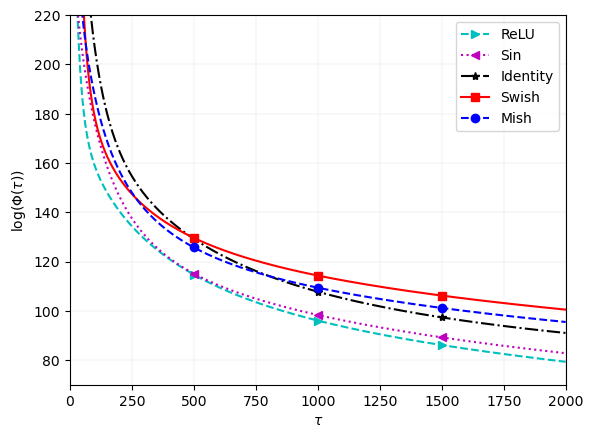

In [35]:
plt.figure(2)
plt.plot(range(epochs), loss_plot3000ReLU,'c--',marker='>',markevery=500)
plt.plot(range(epochs), loss_plot3000sin,'m:',marker='<',markevery=500)
plt.plot(range(epochs), loss_plot3000identity,'k-.',marker='*',markevery=500)
plt.plot(range(epochs), loss_plot3000swish,'r-',marker='s',markevery=500)
plt.plot(range(epochs), loss_plot3000mish,'b--',marker='o',markevery=500)

plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log(\Phi(\tau))$')
plt.legend(['ReLU','Sin','Identity','Swish','Mish'])
plt.savefig('L2loss_cifar_'+str(width)+'_'+str(Wstd)+'.png')
plt.axis([0,2000,70,220])
plt.savefig('code_DEM_comp_MNIST_mod.pdf') 
plt.savefig('code_DEM_comp_MNIST_mod.eps') 
plt.grid(color='k', linestyle='--', linewidth=.05)